In [1]:
!pip install seaborn

In [4]:
# %% [markdown]
# # Pasture Biomass Feature Extraction
# 
# ## Using existing feature extraction functions from the provided code
# 
# **Target Variables** (from annotations):
# - dry_clover_g
# - dry_dead_g  
# - dry_green_g
# - GDM_g
# - dry_total_g

# %% [markdown]
# ## 1. Import Libraries

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Visualization
from IPython.display import display, HTML

# Set random seeds
np.random.seed(42)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [5]:
def load_and_prepare_data(df):
    """
    Load and prepare the dataset from the given format.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns: ['sample_id', 'image_path', 'target_name', 'target']
        
    Returns:
    --------
    images_df : pandas DataFrame
        DataFrame with one row per image and all targets as columns
    """
    
    print(f"Original dataset shape: {df.shape}")
    
    # Create a mapping of image to targets
    image_targets = {}
    
    for _, row in df.iterrows():
        image_path = row['image_path']
        target_name = row['target_name']
        target_value = row['target']
        
        # Extract image ID from sample_id (remove the target suffix)
        image_id = row['sample_id'].split('__')[0]
        
        if image_id not in image_targets:
            image_targets[image_id] = {
                'image_id': image_id,
                'image_path': image_path
            }
        
        # Add target value
        image_targets[image_id][target_name] = target_value
    
    # Convert to DataFrame
    images_df = pd.DataFrame.from_dict(image_targets, orient='index')

    
    
    # Reorder columns
    target_columns = [col for col in images_df.columns if col.endswith(('_g', '_G'))]

    print(f"Target columns found: {target_columns}")

    available_targets = [col for col in target_columns if col in images_df.columns]
    
    images_df = images_df[['image_id', 'image_path'] + available_targets]
    
    print(f"Processed {len(images_df)} unique images")
    print(f"Available targets: {available_targets}")
    
    return images_df



In [7]:
df_sample = pd.read_csv(r'C:\Users\shamr\Downloads\csiro-biomass\train.csv')

print("Sample dataset:")
display(df_sample.head(10))

# Load and prepare the data
images_df = load_and_prepare_data(df_sample)
display(images_df.head())


Sample dataset:


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750
5,ID1012260530__Dry_Clover_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Clover_g,0.0000
6,ID1012260530__Dry_Dead_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Dead_g,0.0000
7,ID1012260530__Dry_Green_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Green_g,7.6000
8,ID1012260530__Dry_Total_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Total_g,7.6000
9,ID1012260530__GDM_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,GDM_g,7.6000


Original dataset shape: (1785, 9)
Target columns found: ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
Processed 357 unique images
Available targets: ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']


,image_id,image_path,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
ID1011485656,ID1011485656,train/ID1011485656.jpg,0.0000,31.9984,16.2751,48.2735,16.2750
ID1012260530,ID1012260530,train/ID1012260530.jpg,0.0000,0.0000,7.6000,7.6000,7.6000
ID1025234388,ID1025234388,train/ID1025234388.jpg,6.0500,0.0000,0.0000,6.0500,6.0500
ID1028611175,ID1028611175,train/ID1028611175.jpg,0.0000,30.9703,24.2376,55.2079,24.2376
ID1035947949,ID1035947949,train/ID1035947949.jpg,0.4343,23.2239,10.5261,34.1844,10.9605


# feature extraction

In [8]:
# %% [markdown]
# ## 3. Feature Extraction Class Based on Provided Code

# %%
class PastureFeatureExtractor:
    """
    Extract features from pasture images using methods from the provided code.
    """
    
    def __init__(self):
        self.feature_names = []
        
    def extract_features_from_image(self, image_path):
        """
        Extract comprehensive features from a single image.
        Based on the detect_dry_clover function from provided code.
        """
        features = {}
        
        # 1. Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not read image from {image_path}")
            return None
        
        # Basic image features
        features['image_height'] = image.shape[0]
        features['image_width'] = image.shape[1]
        features['total_pixels'] = image.shape[0] * image.shape[1]
        
        # 2. Extract color features from HSV space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Color statistics for HSV channels
        hsv_channels = ['H', 'S', 'V']
        for i, channel in enumerate(hsv_channels):
            channel_data = hsv_image[:, :, i].flatten()
            features[f'hsv_{channel.lower()}_mean'] = np.mean(channel_data)
            features[f'hsv_{channel.lower()}_std'] = np.std(channel_data)
            features[f'hsv_{channel.lower()}_min'] = np.min(channel_data)
            features[f'hsv_{channel.lower()}_max'] = np.max(channel_data)
        
        # 3. Extract RGB channel features
        B, G, R = cv2.split(image)
        
        rgb_channels = ['R', 'G', 'B']
        channel_data_list = [R, G, B]
        
        for i, (channel, data) in enumerate(zip(rgb_channels, channel_data_list)):
            data_flat = data.flatten()
            features[f'rgb_{channel.lower()}_mean'] = np.mean(data_flat)
            features[f'rgb_{channel.lower()}_std'] = np.std(data_flat)
            features[f'rgb_{channel.lower()}_min'] = np.min(data_flat)
            features[f'rgb_{channel.lower()}_max'] = np.max(data_flat)
        
        # 4. Dry Clover Detection Features (from provided code)
        lower_dry_clover = np.array([10, 30, 50])
        upper_dry_clover = np.array([40, 150, 220])
        mask_dry_clover = cv2.inRange(hsv_image, lower_dry_clover, upper_dry_clover)
        
        # Morphological operations
        kernel = np.ones((5, 5), np.uint8)
        mask_dry_clover = cv2.morphologyEx(mask_dry_clover, cv2.MORPH_OPEN, kernel)
        
        dry_clover_pixels = cv2.countNonZero(mask_dry_clover)
        features['dry_clover_pixel_count'] = dry_clover_pixels
        features['dry_clover_percentage'] = (dry_clover_pixels / features['total_pixels']) * 100.0
        
        # 5. Dry Dead Material Detection (from provided code)
        lower_brown = np.array([10, 0, 50])
        upper_brown = np.array([40, 255, 255])
        dry_dead_mask = cv2.inRange(hsv_image, lower_brown, upper_brown)
        
        lower_green_hsv = np.array([25, 40, 40])
        upper_green_hsv = np.array([90, 255, 255])
        live_plant_mask = cv2.inRange(hsv_image, lower_green_hsv, upper_green_hsv)
        
        total_plant_mask = cv2.bitwise_or(live_plant_mask, dry_dead_mask)
        
        total_plant_pixels = np.sum(total_plant_mask == 255)
        dry_dead_pixels = np.sum(dry_dead_mask == 255)
        
        features['dry_dead_pixel_count'] = dry_dead_pixels
        features['live_plant_pixel_count'] = np.sum(live_plant_mask == 255)
        features['total_plant_pixel_count'] = total_plant_pixels
        
        if total_plant_pixels > 0:
            features['dry_dead_percentage'] = (dry_dead_pixels / total_plant_pixels) * 100
        else:
            features['dry_dead_percentage'] = 0.0
        
        # 6. Green Pixel Detection (from provided code)
        green_mask = (G > R) & (G > B) & (G > 35)
        green_pixels = np.sum(green_mask)
        
        features['green_pixel_count'] = green_pixels
        features['green_percentage'] = (green_pixels / features['total_pixels']) * 100
        
        # 7. Total Biomass Detection (from provided code)
        lower_green = np.array([25, 40, 40])
        upper_green = np.array([85, 255, 255])
        mask_biomass = cv2.inRange(hsv_image, lower_green, upper_green)
        
        # Morphological operations
        mask_biomass = cv2.erode(mask_biomass, None, iterations=1)
        mask_biomass = cv2.dilate(mask_biomass, None, iterations=1)
        
        biomass_pixel_area = np.sum(mask_biomass == 255)
        features['biomass_pixel_count'] = biomass_pixel_area
        features['biomass_percentage'] = (biomass_pixel_area / features['total_pixels']) * 100
        
        # 8. Color Ratio Features
        features['G_R_ratio'] = np.mean(G) / (np.mean(R) + 1e-7)
        features['G_B_ratio'] = np.mean(G) / (np.mean(B) + 1e-7)
        features['R_B_ratio'] = np.mean(R) / (np.mean(B) + 1e-7)
        
        # 9. Vegetation Indices
        with np.errstate(divide='ignore', invalid='ignore'):
            # Excess Green Index
            features['exg'] = 2 * np.mean(G) - np.mean(R) - np.mean(B)
            
            # Normalized Difference Index
            features['ndi'] = (np.mean(G) - np.mean(R)) / (np.mean(G) + np.mean(R) + 1e-7)
            
            # Color Index of Vegetation
            features['cive'] = 0.441 * np.mean(R) - 0.811 * np.mean(G) + 0.385 * np.mean(B) + 18.78745
        
        # 10. Texture Features (simplified)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Basic texture statistics
        features['gray_mean'] = np.mean(gray)
        features['gray_std'] = np.std(gray)
        features['gray_skew'] = pd.Series(gray.flatten()).skew()
        features['gray_kurtosis'] = pd.Series(gray.flatten()).kurtosis()
        
        # Edge features
        edges = cv2.Canny(gray, 100, 200)
        features['edge_density'] = np.mean(edges > 0) * 100
        
        # 11. Image Entropy (texture complexity)
        from scipy import stats
        hist = np.histogram(gray.flatten(), bins=32, range=(0, 256))[0]
        hist = hist / hist.sum()
        features['entropy'] = stats.entropy(hist + 1e-10)
        
        # 12. Additional Derived Features
        # Coverage ratios
        features['plant_coverage_ratio'] = features['total_plant_pixel_count'] / features['total_pixels']
        features['green_coverage_ratio'] = features['green_pixel_count'] / features['total_pixels']
        features['dry_coverage_ratio'] = features['dry_dead_pixel_count'] / features['total_pixels']
        
        # Health indices
        if features['total_plant_pixel_count'] > 0:
            features['health_index'] = features['green_pixel_count'] / features['total_plant_pixel_count']
            features['dryness_index'] = features['dry_dead_pixel_count'] / features['total_plant_pixel_count']
        else:
            features['health_index'] = 0
            features['dryness_index'] = 0
        
        # Color diversity
        features['color_variance'] = np.var([features['rgb_r_mean'], features['rgb_g_mean'], features['rgb_b_mean']])
        
        return features
    
    def extract_features_from_directory(self, image_dir, image_names):
        """
        Extract features for multiple images.
        
        Parameters:
        -----------
        image_dir : str
            Directory containing images
        image_names : list
            List of image filenames
            
        Returns:
        --------
        features_df : pandas DataFrame
            DataFrame with extracted features
        """
        
        all_features = []
        valid_images = []
        
        print(f"Extracting features from {len(image_names)} images...")
        
        for img_name in tqdm(image_names):
            img_path = os.path.join(image_dir, img_name)
            
            if not os.path.exists(img_path):
                print(f"Warning: Image not found: {img_path}")
                continue
                
            features = self.extract_features_from_image(img_path)
            
            if features is not None:
                features['image_name'] = img_name
                all_features.append(features)
                valid_images.append(img_name)
        
        # Create DataFrame
        if all_features:
            features_df = pd.DataFrame(all_features)
            self.feature_names = [col for col in features_df.columns if col != 'image_name']
            return features_df
        else:
            print("No features extracted!")
            return pd.DataFrame()

In [10]:

# %% [markdown]
# ## 5. Extract Features from Images

# Initialize feature extractor
extractor = PastureFeatureExtractor()

# %%
# Extract features
image_names = images_df['image_path'].apply(lambda x: x.split('/')[-1]).unique().tolist()
features_df = extractor.extract_features_from_directory(r'C:\Users\shamr\Downloads\csiro-biomass\test\test', image_names)

print(f"Extracted {len(features_df)} feature vectors")
print(f"Number of features: {len(extractor.feature_names)}")

# Display extracted features
display(features_df.head())

# Show feature names
print("\nFeature Categories:")
print("=" * 50)
for i, feature in enumerate(extractor.feature_names):
    print(f"{i+1:3d}. {feature}")

Extracting features from 357 images...


 89%|████████▉ | 317/357 [01:43<00:13,  3.01it/s]

 92%|█████████▏| 327/357 [01:46<00:09,  3.31it/s]

 96%|█████████▋| 344/357 [01:51<00:04,  3.21it/s]

 97%|█████████▋| 346/357 [01:51<00:02,  4.10it/s]

100%|██████████| 357/357 [01:54<00:00,  3.12it/s]

Extracted 351 feature vectors
Number of features: 55


,image_height,image_width,total_pixels,hsv_h_mean,hsv_h_std,hsv_h_min,hsv_h_max,hsv_s_mean,hsv_s_std,hsv_s_min,...,gray_kurtosis,edge_density,entropy,plant_coverage_ratio,green_coverage_ratio,dry_coverage_ratio,health_index,dryness_index,color_variance,image_name
0,1000,2000,2000000,39.517308,21.086194,0,179,104.294698,62.335466,0,...,-0.926243,28.16755,3.375680,0.815968,0.609033,0.446325,0.746393,0.546987,212.948600,ID1011485656.jpg
1,1000,2000,2000000,40.527724,43.907434,0,179,70.262946,50.466496,0,...,-1.390507,22.88440,3.302955,0.562601,0.283571,0.381566,0.504036,0.678217,60.210763,ID1012260530.jpg
2,1000,2000,2000000,39.894041,44.208492,0,179,51.719132,51.723087,0,...,-0.924201,30.74050,3.314720,0.627915,0.232128,0.459678,0.369681,0.732070,33.532730,ID1025234388.jpg
3,1000,2000,2000000,39.056849,14.928879,0,179,138.625091,70.464367,0,...,-0.861384,27.20050,3.324213,0.905855,0.741236,0.489630,0.818272,0.540517,488.945220,ID1028611175.jpg
4,1000,2000,2000000,30.029629,8.026798,0,179,145.171941,56.857122,0,...,-0.320703,30.21100,3.168588,0.926955,0.469181,0.830808,0.506153,0.896276,585.096002,ID1035947949.jpg



Feature Categories:
  1. image_height
  2. image_width
  3. total_pixels
  4. hsv_h_mean
  5. hsv_h_std
  6. hsv_h_min
  7. hsv_h_max
  8. hsv_s_mean
  9. hsv_s_std
 10. hsv_s_min
 11. hsv_s_max
 12. hsv_v_mean
 13. hsv_v_std
 14. hsv_v_min
 15. hsv_v_max
 16. rgb_r_mean
 17. rgb_r_std
 18. rgb_r_min
 19. rgb_r_max
 20. rgb_g_mean
 21. rgb_g_std
 22. rgb_g_min
 23. rgb_g_max
 24. rgb_b_mean
 25. rgb_b_std
 26. rgb_b_min
 27. rgb_b_max
 28. dry_clover_pixel_count
 29. dry_clover_percentage
 30. dry_dead_pixel_count
 31. live_plant_pixel_count
 32. total_plant_pixel_count
 33. dry_dead_percentage
 34. green_pixel_count
 35. green_percentage
 36. biomass_pixel_count
 37. biomass_percentage
 38. G_R_ratio
 39. G_B_ratio
 40. R_B_ratio
 41. exg
 42. ndi
 43. cive
 44. gray_mean
 45. gray_std
 46. gray_skew
 47. gray_kurtosis
 48. edge_density
 49. entropy
 50. plant_coverage_ratio
 51. green_coverage_ratio
 52. dry_coverage_ratio
 53. health_index
 54. dryness_index
 55. color_variance


In [11]:
# Add image_name column to features_df
if 'image_name' not in features_df.columns:
    features_df['image_name'] = image_names[:len(features_df)]

# Add image_name column to images_df
images_df['image_name'] = images_df['image_path'].apply(lambda x: x.split('/')[-1])

# Merge features with targets
df_merged = pd.merge(features_df, images_df, on='image_name', how='inner')

print("Merged dataset shape:", df_merged.shape)
print("\nColumns in merged dataset:")
print(df_merged.columns.tolist())

# Display first few rows
display(df_merged.head())

# Check which target columns we have
target_cols = [col for col in df_merged.columns if any(x in col.lower() for x in 
               ['clover', 'dead', 'green', 'total', 'gdm'])]
print(f"\nTarget columns found: {target_cols}")

Merged dataset shape: (351, 63)

Columns in merged dataset:
['image_height', 'image_width', 'total_pixels', 'hsv_h_mean', 'hsv_h_std', 'hsv_h_min', 'hsv_h_max', 'hsv_s_mean', 'hsv_s_std', 'hsv_s_min', 'hsv_s_max', 'hsv_v_mean', 'hsv_v_std', 'hsv_v_min', 'hsv_v_max', 'rgb_r_mean', 'rgb_r_std', 'rgb_r_min', 'rgb_r_max', 'rgb_g_mean', 'rgb_g_std', 'rgb_g_min', 'rgb_g_max', 'rgb_b_mean', 'rgb_b_std', 'rgb_b_min', 'rgb_b_max', 'dry_clover_pixel_count', 'dry_clover_percentage', 'dry_dead_pixel_count', 'live_plant_pixel_count', 'total_plant_pixel_count', 'dry_dead_percentage', 'green_pixel_count', 'green_percentage', 'biomass_pixel_count', 'biomass_percentage', 'G_R_ratio', 'G_B_ratio', 'R_B_ratio', 'exg', 'ndi', 'cive', 'gray_mean', 'gray_std', 'gray_skew', 'gray_kurtosis', 'edge_density', 'entropy', 'plant_coverage_ratio', 'green_coverage_ratio', 'dry_coverage_ratio', 'health_index', 'dryness_index', 'color_variance', 'image_name', 'image_id', 'image_path', 'Dry_Clover_g', 'Dry_Dead_g', 'Dr

,image_height,image_width,total_pixels,hsv_h_mean,hsv_h_std,hsv_h_min,hsv_h_max,hsv_s_mean,hsv_s_std,hsv_s_min,...,dryness_index,color_variance,image_name,image_id,image_path,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,1000,2000,2000000,39.517308,21.086194,0,179,104.294698,62.335466,0,...,0.546987,212.948600,ID1011485656.jpg,ID1011485656,train/ID1011485656.jpg,0.0000,31.9984,16.2751,48.2735,16.2750
1,1000,2000,2000000,40.527724,43.907434,0,179,70.262946,50.466496,0,...,0.678217,60.210763,ID1012260530.jpg,ID1012260530,train/ID1012260530.jpg,0.0000,0.0000,7.6000,7.6000,7.6000
2,1000,2000,2000000,39.894041,44.208492,0,179,51.719132,51.723087,0,...,0.732070,33.532730,ID1025234388.jpg,ID1025234388,train/ID1025234388.jpg,6.0500,0.0000,0.0000,6.0500,6.0500
3,1000,2000,2000000,39.056849,14.928879,0,179,138.625091,70.464367,0,...,0.540517,488.945220,ID1028611175.jpg,ID1028611175,train/ID1028611175.jpg,0.0000,30.9703,24.2376,55.2079,24.2376
4,1000,2000,2000000,30.029629,8.026798,0,179,145.171941,56.857122,0,...,0.896276,585.096002,ID1035947949.jpg,ID1035947949,train/ID1035947949.jpg,0.4343,23.2239,10.5261,34.1844,10.9605



Target columns found: ['total_pixels', 'dry_clover_pixel_count', 'dry_clover_percentage', 'dry_dead_pixel_count', 'total_plant_pixel_count', 'dry_dead_percentage', 'green_pixel_count', 'green_percentage', 'green_coverage_ratio', 'Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']


In [13]:

# Separate features (X) and targets (y)
X = df_merged[extractor.feature_names]
y = df_merged[['Dry_Clover_g','Dry_Dead_g','Dry_Green_g','GDM_g','Dry_Total_g']]

print("\nFeature matrix shape (X):", X.shape)
print("Target matrix shape (y):", y.shape)


Feature matrix shape (X): (351, 55)
Target matrix shape (y): (351, 5)


In [14]:
# %% [markdown]
# ## 7. Exploratory Data Analysis

# %%
# 1. Feature Statistics
print("Feature Statistics:")
print("=" * 60)
feature_stats = X.describe().T
feature_stats['missing'] = X.isnull().sum()
feature_stats['missing_pct'] = (feature_stats['missing'] / len(X)) * 100
display(feature_stats[['mean', 'std', 'min', 'max', 'missing_pct']].head(15))

Feature Statistics:


,mean,std,min,max,missing_pct
image_height,1.000000e+03,0.000000,1.000000e+03,1.000000e+03,0.0
image_width,2.000000e+03,0.000000,2.000000e+03,2.000000e+03,0.0
total_pixels,2.000000e+06,0.000000,2.000000e+06,2.000000e+06,0.0
hsv_h_mean,4.257464e+01,14.707683,1.841368e+01,1.395380e+02,0.0
hsv_h_std,1.619668e+01,13.390729,3.571506e+00,6.908405e+01,0.0
hsv_h_min,2.250712e-01,1.286434,0.000000e+00,1.500000e+01,0.0
hsv_h_max,1.722991e+02,24.169614,6.500000e+01,1.790000e+02,0.0
hsv_s_mean,1.250874e+02,39.025555,2.135718e+01,1.990967e+02,0.0
hsv_s_std,5.671335e+01,11.402724,1.459157e+01,7.424592e+01,0.0
hsv_s_min,4.615385e-01,1.694724,0.000000e+00,1.300000e+01,0.0


In [15]:
# 2. Target Variable Analysis
print("\nTarget Variable Statistics:")
print("=" * 60)
target_stats = y.describe().T
display(target_stats)

# 3. Correlation Analysis
plt.figure(figsize=(15, 10))


Target Variable Statistics:


,count,mean,std,min,25%,50%,75%,max
Dry_Clover_g,351.0,6.569099,12.114207,0.00,0.00000,1.3191,7.20410,71.7865
Dry_Dead_g,351.0,12.156128,12.448620,0.00,3.27435,8.0000,17.81985,83.8407
Dry_Green_g,351.0,26.835770,25.502083,0.00,8.87000,20.9000,35.24555,157.9836
GDM_g,351.0,33.404867,25.099053,1.04,15.83915,27.1111,44.27055,157.9836
Dry_Total_g,351.0,45.560115,28.134827,1.04,25.38575,40.6000,58.27000,185.7000


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

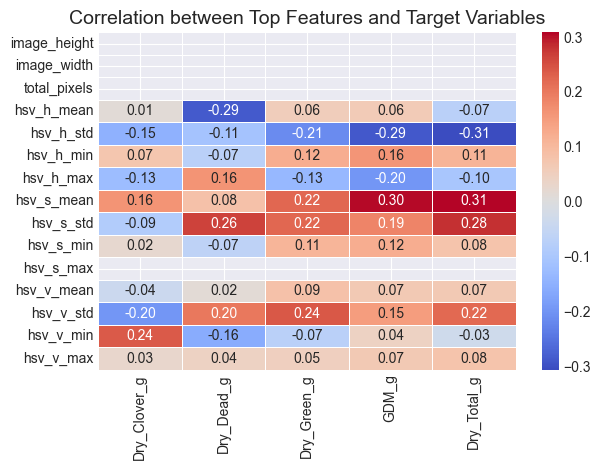

In [16]:

# Select top features for correlation visualization
top_features = X.columns[:15]  # First 15 features

# Calculate correlation with targets
corr_with_targets = pd.DataFrame(index=top_features)

for target in y.columns:
    correlations = []
    for feature in top_features:
        correlation = X[feature].corr(y[target])
        correlations.append(correlation)
    corr_with_targets[target] = correlations

# Plot heatmap
sns.heatmap(corr_with_targets, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5)
plt.title('Correlation between Top Features and Target Variables', fontsize=14)
plt.tight_layout()
plt.show()


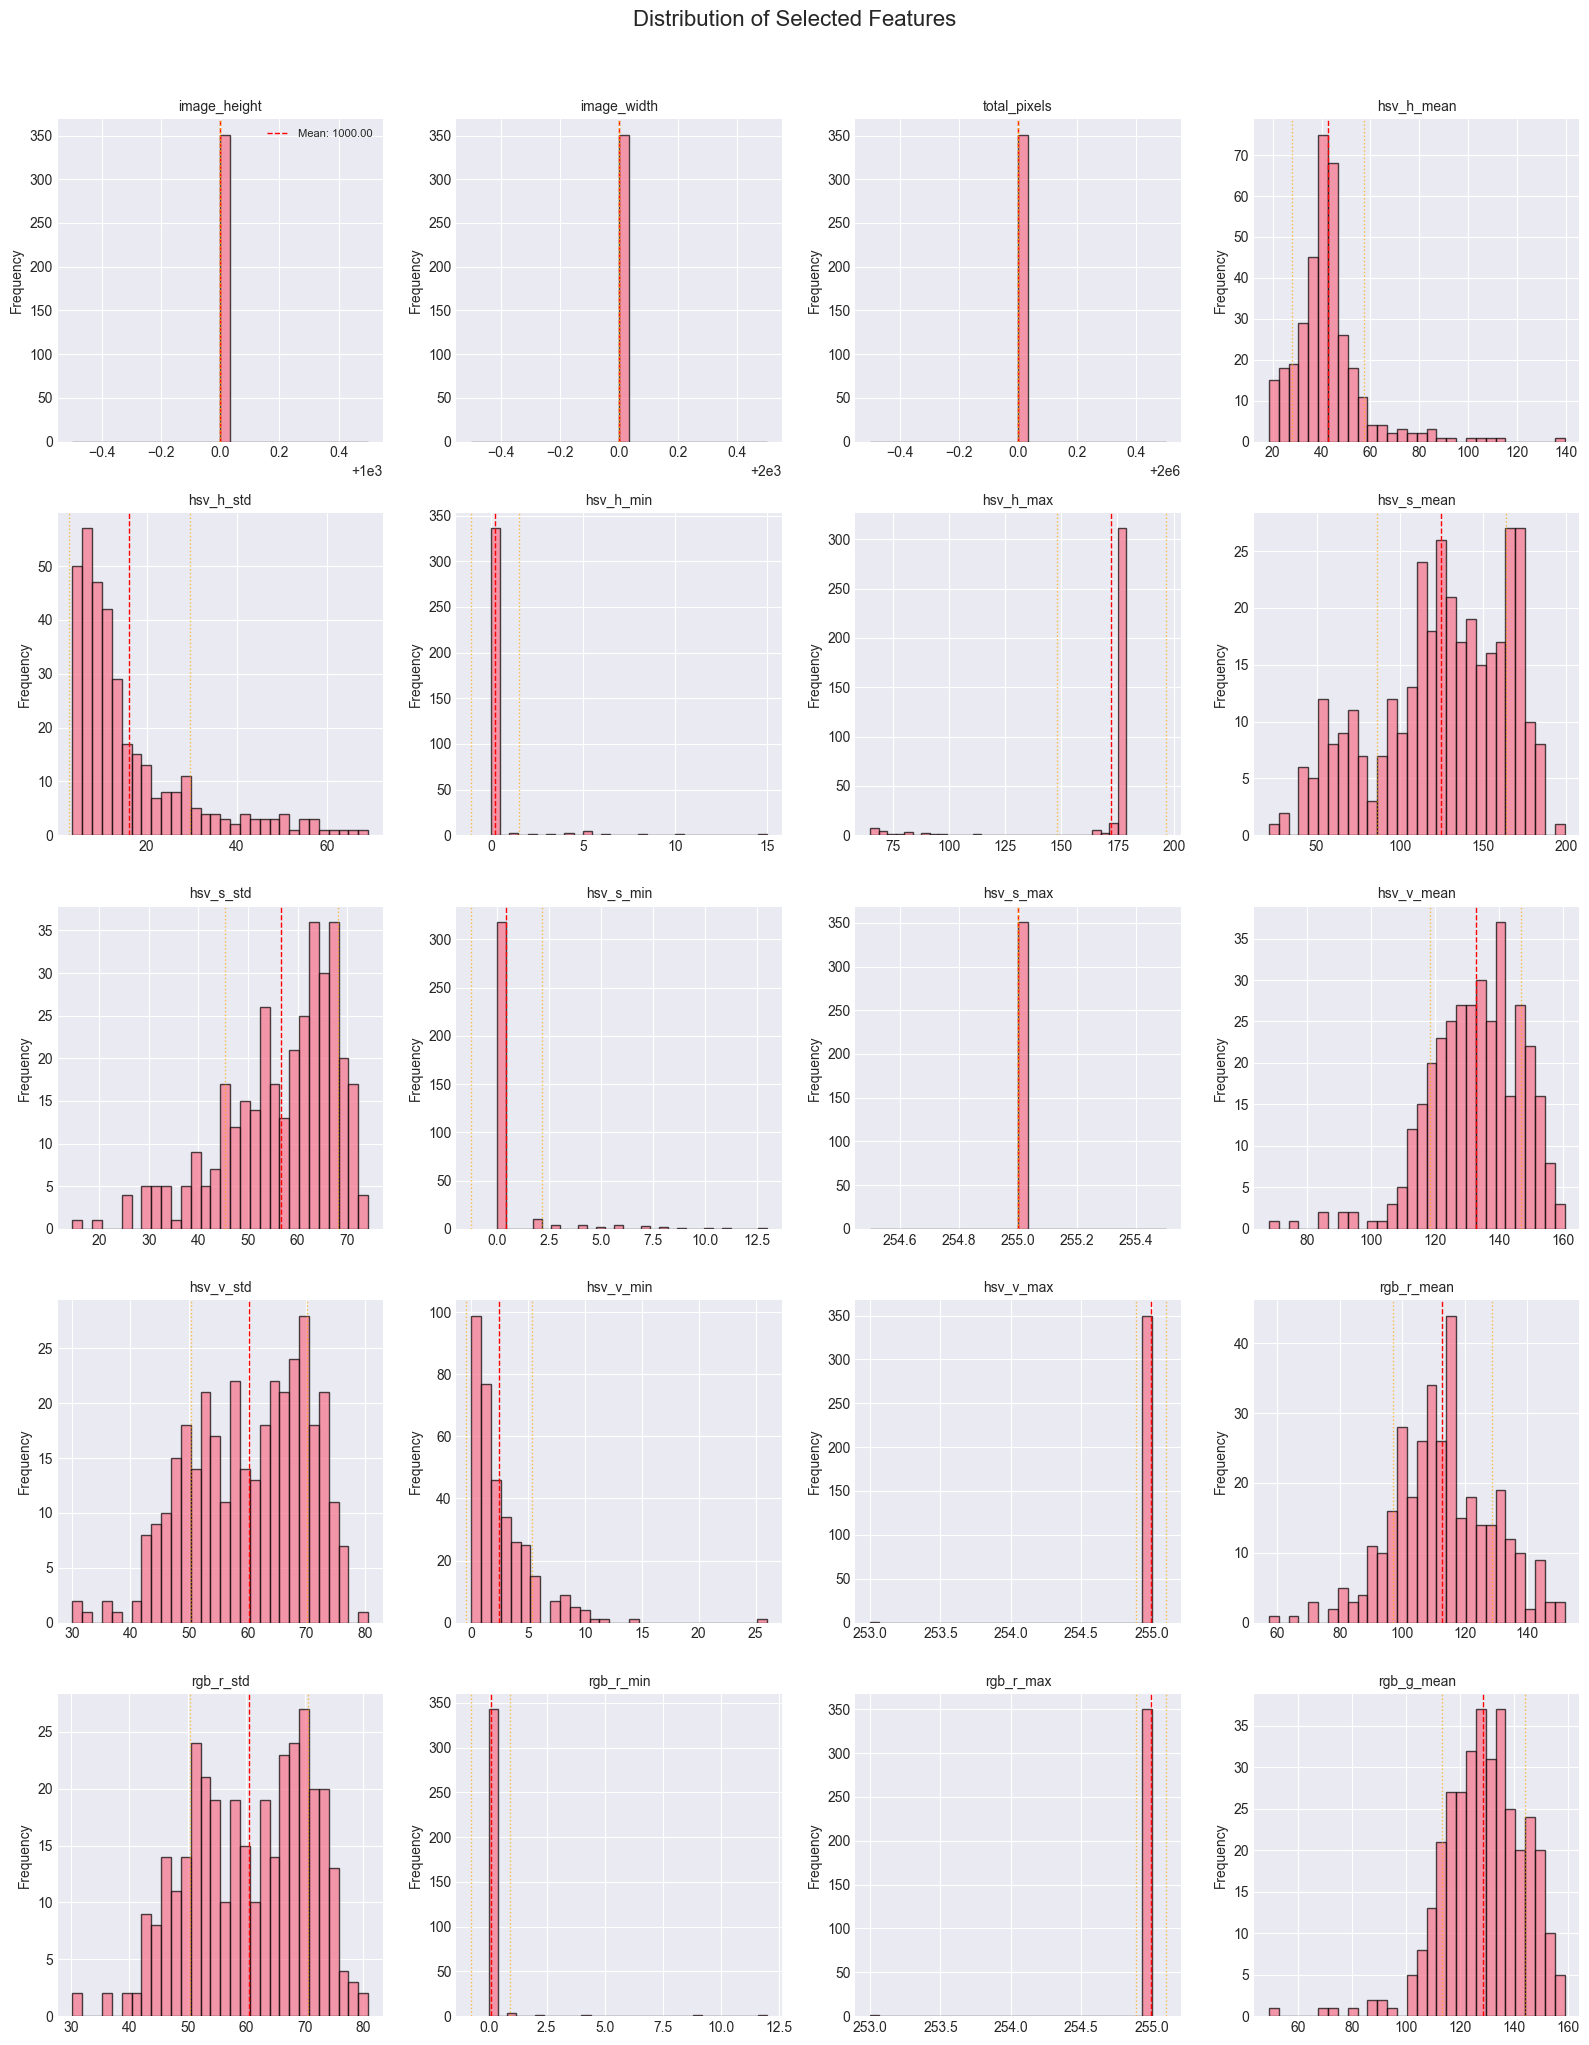

In [17]:
# 4. Feature Distributions
fig, axes = plt.subplots(5, 4, figsize=(16, 20))
axes = axes.flatten()

selected_features = X.columns[:20]  # Plot first 20 features

for idx, feature in enumerate(selected_features):
    if idx < len(axes):
        ax = axes[idx]
        X[feature].hist(ax=ax, bins=30, edgecolor='black', alpha=0.7)
        ax.set_title(f'{feature[:20]}...' if len(feature) > 20 else feature, fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Frequency')
        
        # Add statistics
        mean_val = X[feature].mean()
        std_val = X[feature].std()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}')
        ax.axvline(mean_val + std_val, color='orange', linestyle=':', linewidth=1, alpha=0.7)
        ax.axvline(mean_val - std_val, color='orange', linestyle=':', linewidth=1, alpha=0.7)
        
        if idx == 0:
            ax.legend(fontsize=8)

# Hide empty subplots
for idx in range(len(selected_features), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribution of Selected Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


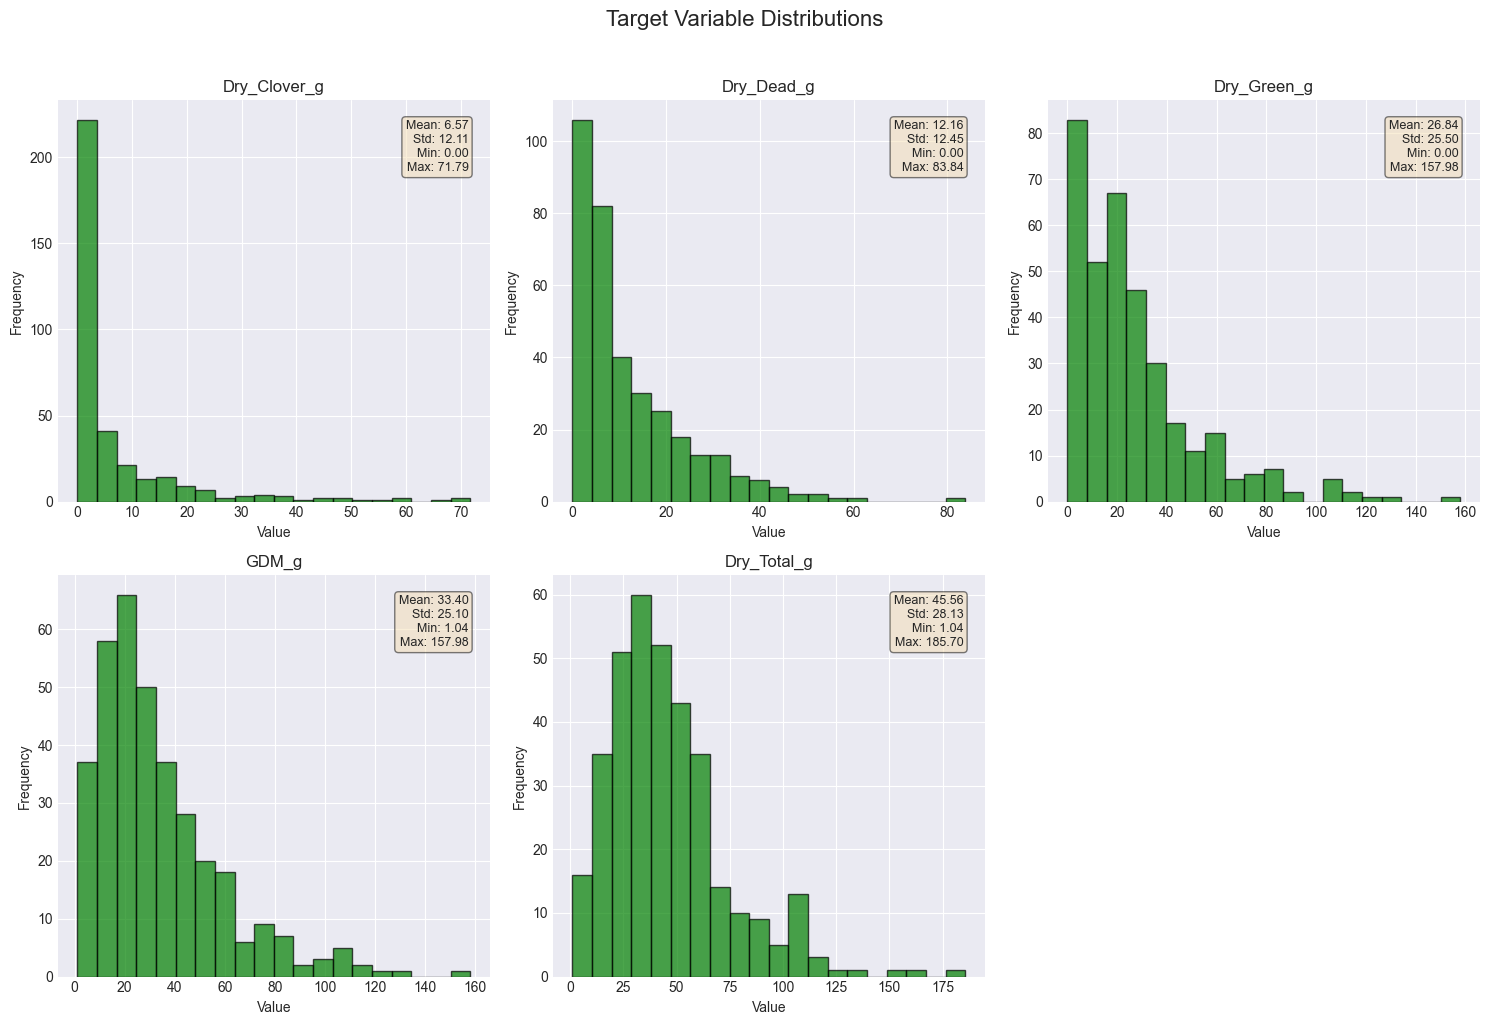

In [18]:
# 5. Target Variable Distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, target in enumerate(y.columns):
    ax = axes[idx]
    y[target].hist(ax=ax, bins=20, edgecolor='black', alpha=0.7, color='green')
    ax.set_title(target, fontsize=12)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Add statistics
    stats_text = f'Mean: {y[target].mean():.2f}\nStd: {y[target].std():.2f}\nMin: {y[target].min():.2f}\nMax: {y[target].max():.2f}'
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Hide empty subplot
if len(y.columns) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Target Variable Distributions', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

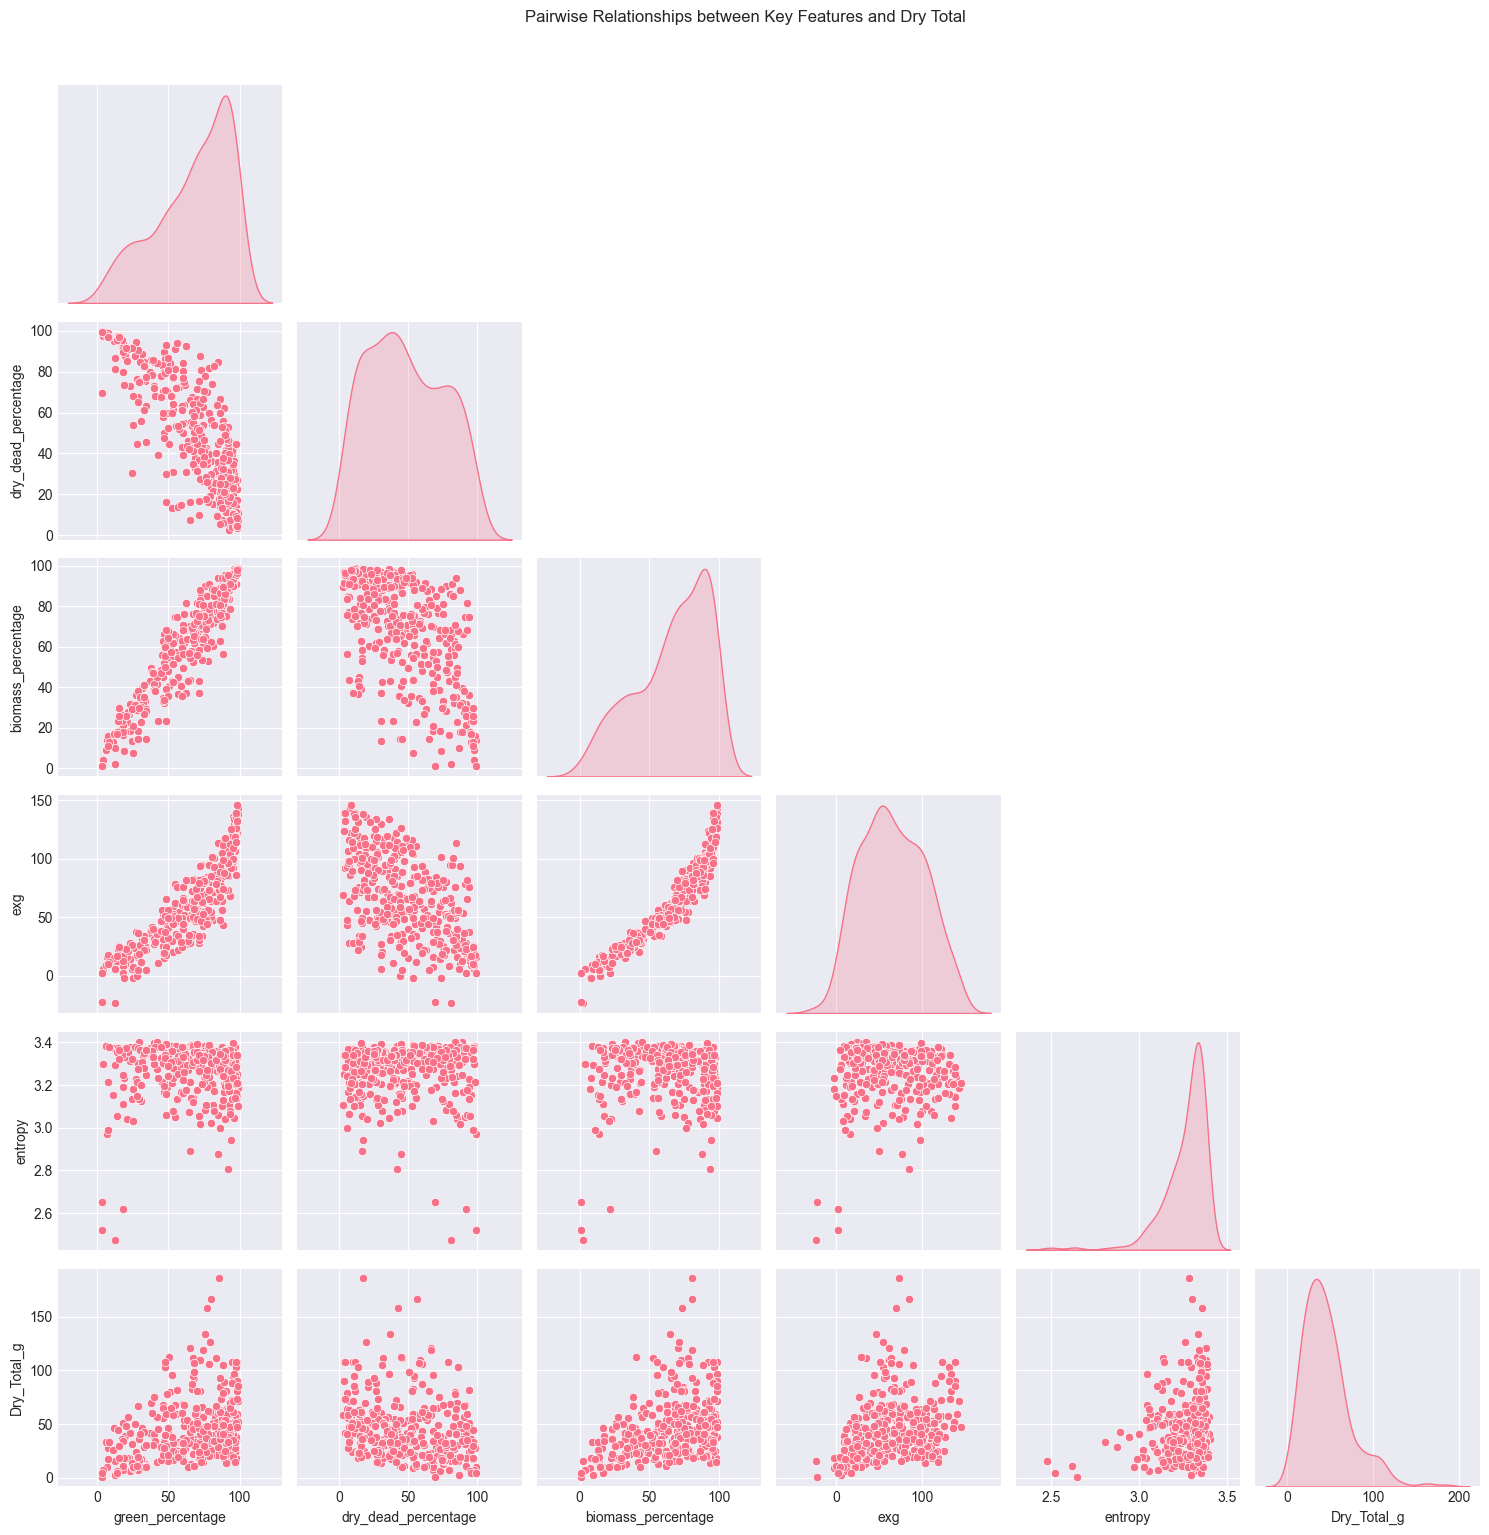

In [20]:

# 6. Pairwise Relationships
# Select key features for pairwise plotting
key_features = [
    'green_percentage',
    'dry_dead_percentage', 
    'biomass_percentage',
    'exg',
    'entropy'
]

# Create pairplot
pairplot_data = pd.concat([X[key_features], y['Dry_Total_g']], axis=1)
sns.pairplot(pairplot_data, diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships between Key Features and Dry Total', y=1.02)
plt.tight_layout()
plt.show()

In [21]:
# %% [markdown]
# ## 8. Feature Engineering: Create Additional Features

# %%
def create_additional_features(df_features):
    """
    Create additional engineered features based on existing ones.
    """
    df = df_features.copy()
    
    # 1. Ratios and proportions
    if 'green_pixel_count' in df.columns and 'total_pixels' in df.columns:
        df['green_coverage'] = df['green_pixel_count'] / df['total_pixels']
    
    if 'dry_dead_pixel_count' in df.columns and 'total_pixels' in df.columns:
        df['dry_coverage'] = df['dry_dead_pixel_count'] / df['total_pixels']
    
    if 'dry_clover_pixel_count' in df.columns and 'total_pixels' in df.columns:
        df['clover_coverage'] = df['dry_clover_pixel_count'] / df['total_pixels']
    
    # 2. Vegetation health indices
    if 'green_pixel_count' in df.columns and 'total_plant_pixel_count' in df.columns:
        df['vegetation_health_index'] = df['green_pixel_count'] / (df['total_plant_pixel_count'] + 1e-7)
    
    if 'dry_dead_pixel_count' in df.columns and 'total_plant_pixel_count' in df.columns:
        df['vegetation_stress_index'] = df['dry_dead_pixel_count'] / (df['total_plant_pixel_count'] + 1e-7)
    
    # 3. Color diversity measures
    if all(col in df.columns for col in ['rgb_r_mean', 'rgb_g_mean', 'rgb_b_mean']):
        df['color_variance'] = df[['rgb_r_mean', 'rgb_g_mean', 'rgb_b_mean']].var(axis=1)
        df['color_range'] = df[['rgb_r_mean', 'rgb_g_mean', 'rgb_b_mean']].max(axis=1) - \
                           df[['rgb_r_mean', 'rgb_g_mean', 'rgb_b_mean']].min(axis=1)
    
    # 4. Texture complexity
    if 'entropy' in df.columns and 'edge_density' in df.columns:
        df['texture_complexity'] = df['entropy'] * df['edge_density']
    
    # 5. Growth potential indicators
    if 'exg' in df.columns and 'ndi' in df.columns:
        df['vegetation_vigor'] = (df['exg'] + df['ndi']) / 2
        
        # Normalize to 0-1 scale
        df['vegetation_vigor_norm'] = (df['vegetation_vigor'] - df['vegetation_vigor'].min()) / \
                                     (df['vegetation_vigor'].max() - df['vegetation_vigor'].min() + 1e-7)
    
    # 6. Biomass density estimate
    if 'biomass_percentage' in df.columns and 'vegetation_vigor_norm' in df.columns:
        df['biomass_density_index'] = df['biomass_percentage'] * df['vegetation_vigor_norm']
    
    # 7. Season/health indicators
    if 'hsv_h_mean' in df.columns:
        # Hue can indicate plant health/season
        df['hue_variation'] = df['hsv_h_std'] / (df['hsv_h_mean'] + 1e-7)
    
    # 8. Combined vegetation indices
    if all(col in df.columns for col in ['exg', 'cive', 'ndi']):
        df['combined_vegetation_index'] = (df['exg'] + df['cive'] + df['ndi']) / 3
    
    return df

# %%
# Apply feature engineering
X_enhanced = create_additional_features(X)

print(f"Original features: {X.shape[1]}")
print(f"Enhanced features: {X_enhanced.shape[1]}")
print(f"Added {X_enhanced.shape[1] - X.shape[1]} new features")

# Display new features
new_features = [col for col in X_enhanced.columns if col not in X.columns]
print("\nNew engineered features:")
for i, feature in enumerate(new_features):
    print(f"{i+1:3d}. {feature}")

Original features: 55
Enhanced features: 67
Added 12 new features

New engineered features:
  1. green_coverage
  2. dry_coverage
  3. clover_coverage
  4. vegetation_health_index
  5. vegetation_stress_index
  6. color_range
  7. texture_complexity
  8. vegetation_vigor
  9. vegetation_vigor_norm
 10. biomass_density_index
 11. hue_variation
 12. combined_vegetation_index


In [22]:
# %% [markdown]
# ## 9. Feature Selection Analysis

# %%
def analyze_feature_importance(X, y, target_name='dry_total_g'):
    """
    Analyze feature importance for a specific target.
    """
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.feature_selection import mutual_info_regression
    
    # Prepare data
    X_filled = X.fillna(X.mean())
    
    # Method 1: Random Forest Importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_filled, y[target_name])
    
    rf_importance = pd.DataFrame({
        'feature': X.columns,
        'rf_importance': rf.feature_importances_
    }).sort_values('rf_importance', ascending=False)
    
    # Method 2: Mutual Information
    mi_scores = mutual_info_regression(X_filled, y[target_name], random_state=42)
    mi_importance = pd.DataFrame({
        'feature': X.columns,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)
    
    # Method 3: Correlation
    correlations = []
    for feature in X.columns:
        corr = X[feature].corr(y[target_name])
        correlations.append(abs(corr) if not pd.isna(corr) else 0)
    
    corr_importance = pd.DataFrame({
        'feature': X.columns,
        'abs_correlation': correlations
    }).sort_values('abs_correlation', ascending=False)
    
    # Combine results
    importance_df = pd.merge(rf_importance, mi_importance, on='feature', how='outer')
    importance_df = pd.merge(importance_df, corr_importance, on='feature', how='outer')
    
    # Normalize scores
    importance_df['rf_importance_norm'] = importance_df['rf_importance'] / importance_df['rf_importance'].max()
    importance_df['mi_score_norm'] = importance_df['mi_score'] / importance_df['mi_score'].max()
    importance_df['abs_correlation_norm'] = importance_df['abs_correlation'] / importance_df['abs_correlation'].max()
    
    # Combined score (average of normalized scores)
    importance_df['combined_score'] = importance_df[['rf_importance_norm', 'mi_score_norm', 'abs_correlation_norm']].mean(axis=1)
    importance_df = importance_df.sort_values('combined_score', ascending=False)
    
    return importance_df

Analyzing feature importance...

Feature Importance for Dry_Clover_g:
----------------------------------------


,feature,rf_importance,mi_score,abs_correlation,rf_importance_norm,mi_score_norm,abs_correlation_norm,combined_score
0,edge_density,0.094430,0.210359,0.314677,1.000000,1.000000,0.952656,0.984219
2,texture_complexity,0.065275,0.204661,0.330316,0.691253,0.972916,1.000000,0.888056
1,hue_variation,0.080735,0.099433,0.189598,0.854973,0.472684,0.573990,0.633882
15,rgb_b_std,0.019818,0.115639,0.301577,0.209870,0.549725,0.912995,0.557530
36,biomass_density_index,0.006618,0.179088,0.247455,0.070087,0.851344,0.749148,0.556860
29,G_B_ratio,0.009886,0.180602,0.212740,0.104694,0.858544,0.644052,0.535763
26,G_R_ratio,0.010486,0.134555,0.257076,0.111050,0.639645,0.778274,0.509656
44,ndi,0.005250,0.136681,0.242679,0.055592,0.649752,0.734689,0.480011
28,live_plant_pixel_count,0.009968,0.127417,0.208605,0.105558,0.605714,0.631531,0.447601
7,entropy,0.033992,0.067692,0.214956,0.359974,0.321795,0.650758,0.444176


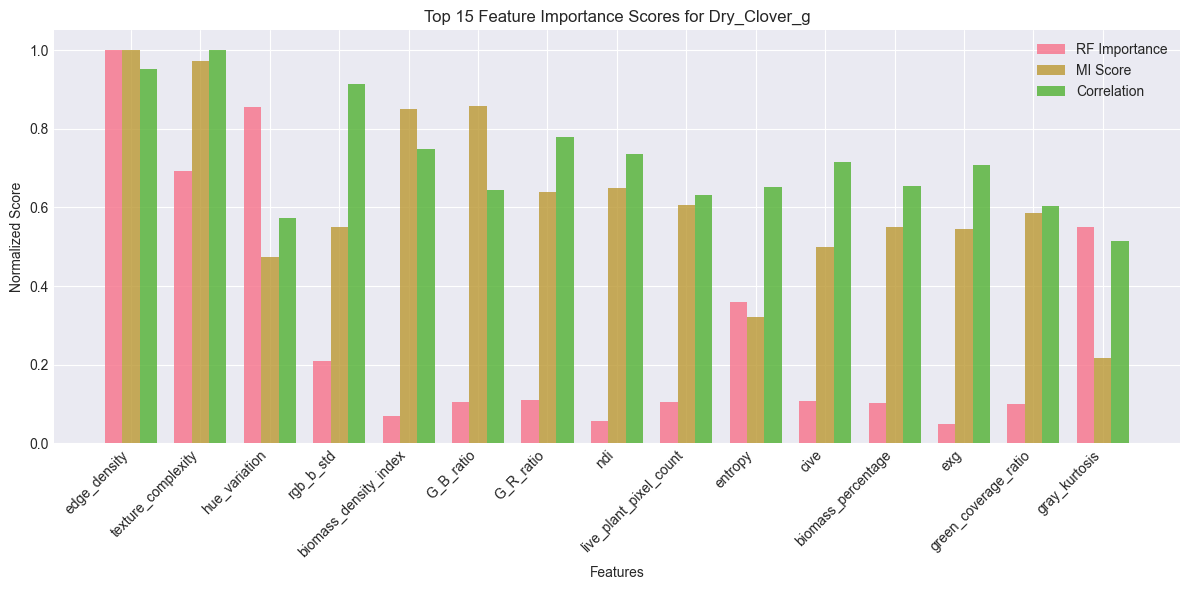


Feature Importance for Dry_Dead_g:
----------------------------------------


,feature,rf_importance,mi_score,abs_correlation,rf_importance_norm,mi_score_norm,abs_correlation_norm,combined_score
0,hsv_h_mean,0.084243,0.057710,0.286270,1.000000,0.366822,0.847028,0.737950
2,hsv_s_std,0.060982,0.083345,0.263063,0.723877,0.529769,0.778365,0.677337
3,entropy,0.059746,0.096866,0.229281,0.709210,0.615715,0.678408,0.667778
1,rgb_b_std,0.083347,0.020448,0.289216,0.989365,0.129974,0.855745,0.658361
5,vegetation_health_index,0.030485,0.107894,0.271483,0.361869,0.685812,0.803277,0.616986
6,health_index,0.029194,0.107894,0.271483,0.346546,0.685812,0.803277,0.611878
13,rgb_r_mean,0.020128,0.108250,0.188788,0.238929,0.688075,0.558595,0.495200
35,vegetation_stress_index,0.009297,0.046858,0.314604,0.110358,0.297844,0.930865,0.446355
39,dryness_index,0.007923,0.046858,0.314604,0.094045,0.297844,0.930865,0.440918
41,dry_dead_percentage,0.007219,0.046858,0.314604,0.085686,0.297844,0.930865,0.438132


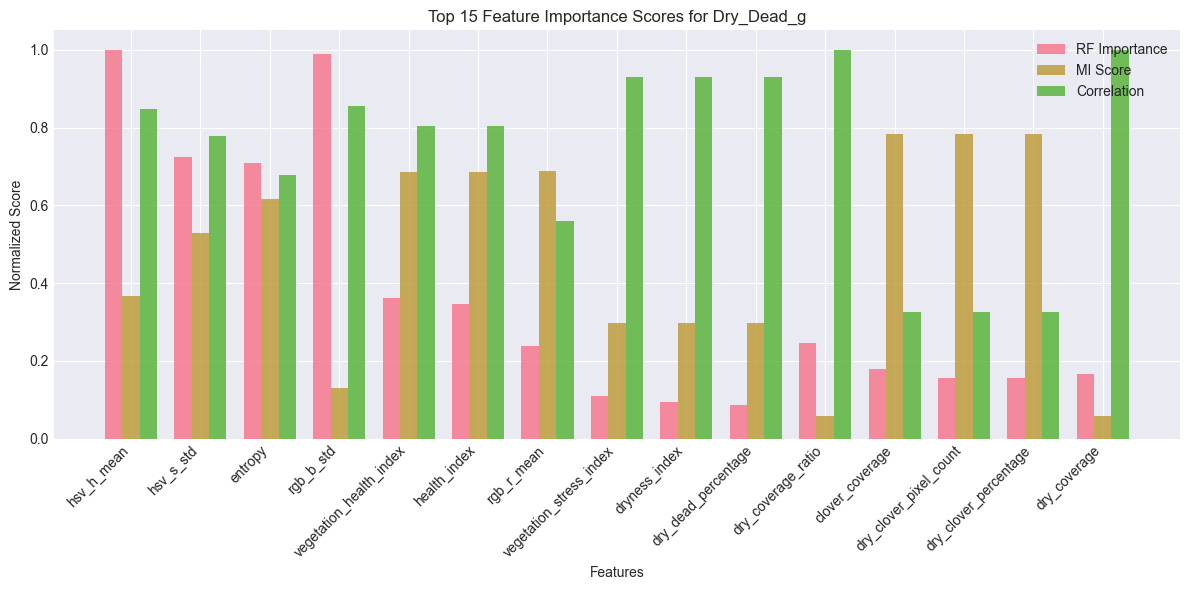


Feature Importance for Dry_Green_g:
----------------------------------------


,feature,rf_importance,mi_score,abs_correlation,rf_importance_norm,mi_score_norm,abs_correlation_norm,combined_score
0,edge_density,0.115407,0.204747,0.301896,1.000000,0.731090,0.855082,0.862057
14,live_plant_pixel_count,0.018847,0.280057,0.327389,0.163308,1.000000,0.927285,0.696864
34,biomass_percentage,0.010593,0.274382,0.320850,0.091787,0.979733,0.908766,0.660095
37,biomass_pixel_count,0.007461,0.274382,0.320850,0.064646,0.979733,0.908766,0.651048
1,rgb_b_std,0.111023,0.044912,0.259358,0.962010,0.160366,0.734599,0.618992
33,biomass_density_index,0.010861,0.263404,0.274049,0.094108,0.940535,0.776209,0.603617
17,green_coverage,0.018006,0.176936,0.353061,0.156020,0.631784,1.000000,0.595935
20,green_coverage_ratio,0.015297,0.176936,0.353061,0.132550,0.631784,1.000000,0.588111
25,green_pixel_count,0.013698,0.176936,0.353061,0.118691,0.631784,1.000000,0.583492
31,green_percentage,0.011578,0.176936,0.353061,0.100327,0.631784,1.000000,0.577370


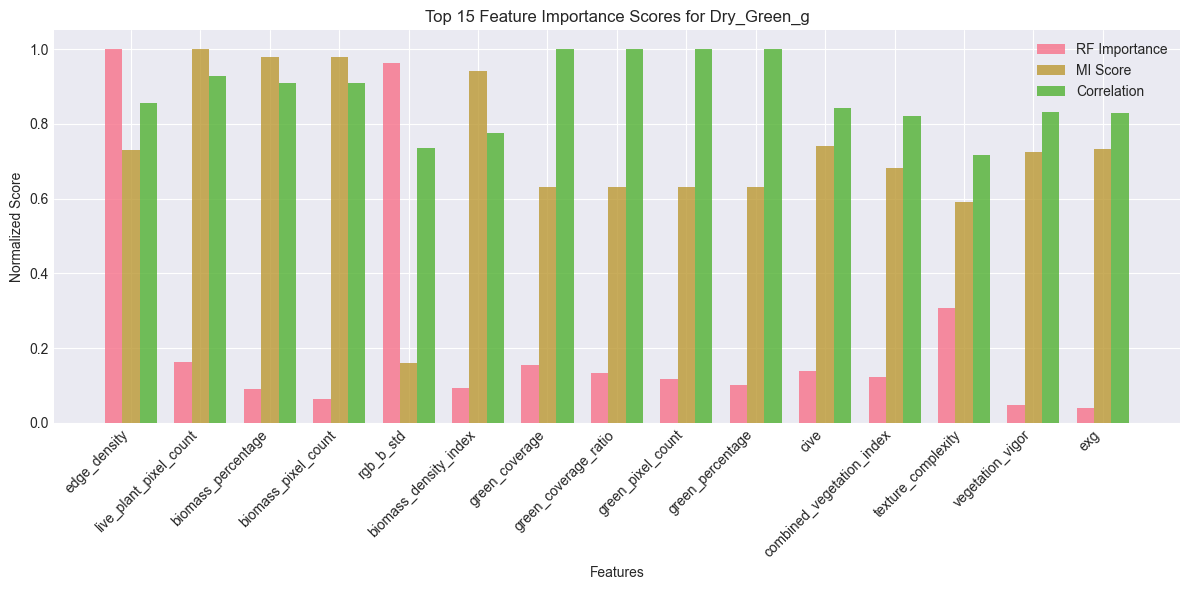


Feature Importance for GDM_g:
----------------------------------------


,feature,rf_importance,mi_score,abs_correlation,rf_importance_norm,mi_score_norm,abs_correlation_norm,combined_score
0,edge_density,0.248393,0.182426,0.458625,1.000000,0.554961,0.992552,0.849171
3,ndi,0.039638,0.260088,0.462066,0.159577,0.791218,1.000000,0.650265
44,vegetation_vigor_norm,0.005072,0.328719,0.410617,0.020420,1.000000,0.888654,0.636358
50,vegetation_vigor,0.004421,0.328719,0.410617,0.017797,1.000000,0.888654,0.635484
43,exg,0.005306,0.327634,0.410418,0.021361,0.996700,0.888222,0.635428
15,combined_vegetation_index,0.018056,0.311609,0.406349,0.072692,0.947950,0.879416,0.633353
7,G_R_ratio,0.025252,0.254511,0.461719,0.101661,0.774251,0.999248,0.625053
14,biomass_density_index,0.018758,0.306328,0.397885,0.075519,0.931885,0.861100,0.622835
19,cive,0.014411,0.296613,0.416639,0.058018,0.902332,0.901686,0.620679
9,green_coverage,0.022109,0.252870,0.454868,0.089008,0.769258,0.984420,0.614229


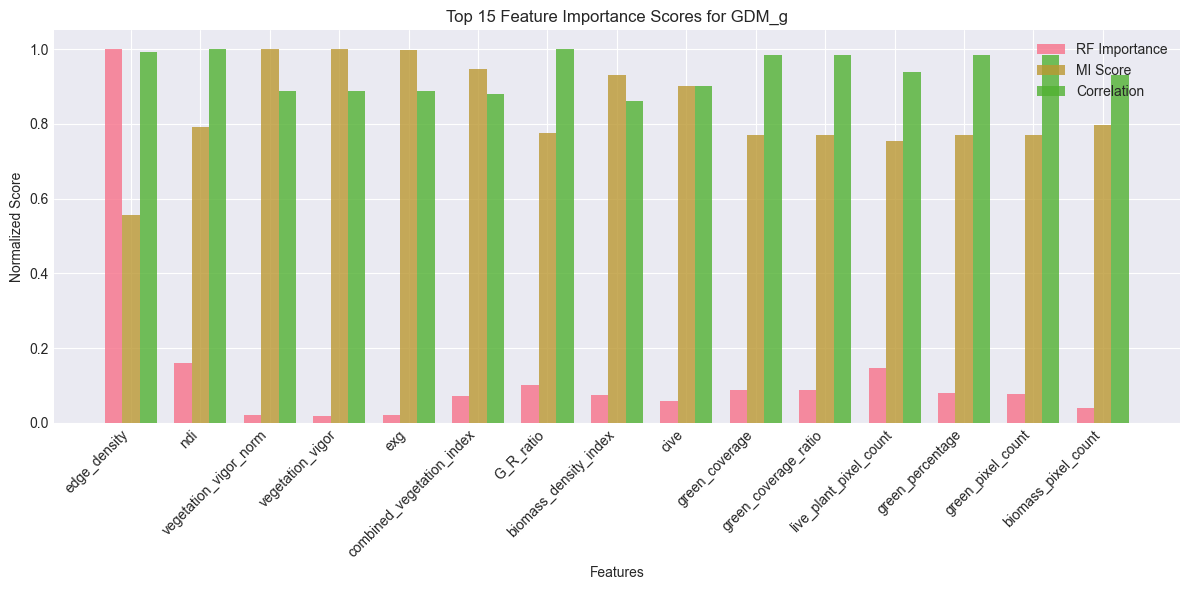


Feature Importance for Dry_Total_g:
----------------------------------------


,feature,rf_importance,mi_score,abs_correlation,rf_importance_norm,mi_score_norm,abs_correlation_norm,combined_score
0,edge_density,0.174998,0.112300,0.353185,1.000000,0.591547,1.000000,0.863849
7,combined_vegetation_index,0.026458,0.189841,0.321799,0.151193,1.000000,0.911132,0.687442
14,biomass_percentage,0.017703,0.180754,0.342428,0.101159,0.952130,0.969543,0.674277
3,live_plant_pixel_count,0.037047,0.153310,0.348297,0.211698,0.807568,0.986160,0.668476
31,biomass_pixel_count,0.010026,0.180754,0.342428,0.057291,0.952130,0.969543,0.659654
20,vegetation_vigor,0.013011,0.175197,0.323068,0.074348,0.922862,0.914727,0.637312
8,cive,0.025117,0.156397,0.324704,0.143530,0.823828,0.919358,0.628905
43,vegetation_vigor_norm,0.006442,0.175197,0.323068,0.036812,0.922862,0.914727,0.624800
41,exg,0.008175,0.172820,0.323004,0.046714,0.910342,0.914547,0.623867
5,hue_variation,0.033936,0.135512,0.334702,0.193922,0.713817,0.947666,0.618468


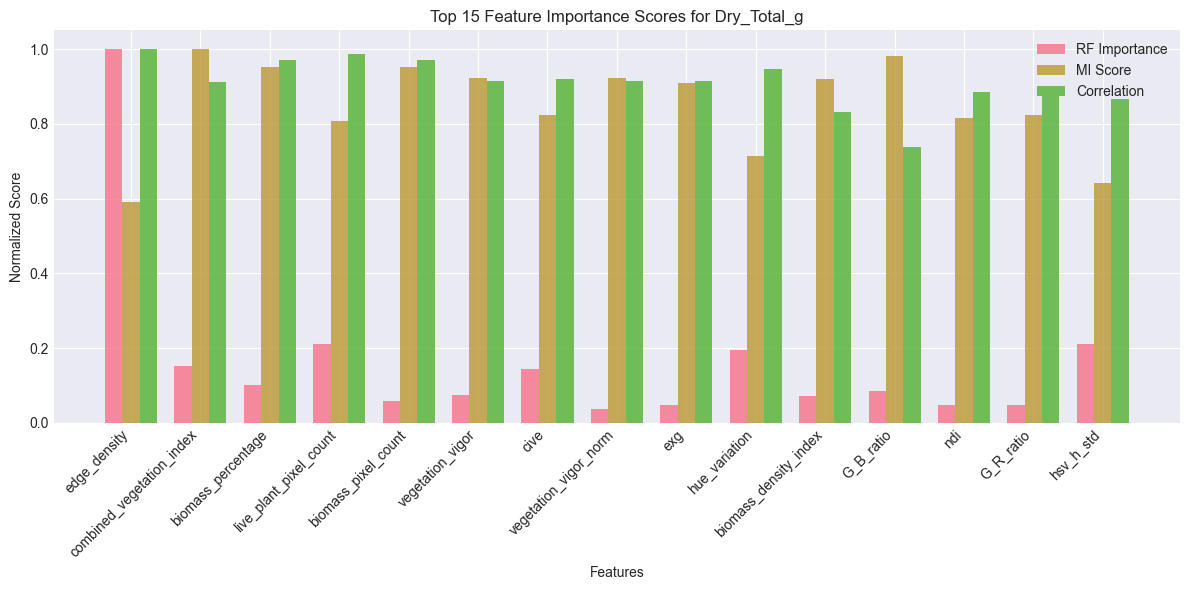

In [23]:
# %%
# Analyze feature importance for each target
print("Analyzing feature importance...")
print("=" * 60)

for target in y.columns:
    print(f"\nFeature Importance for {target}:")
    print("-" * 40)
    
    importance_df = analyze_feature_importance(X_enhanced, y, target)
    
    # Display top 10 features
    display(importance_df.head(10))
    
    # Plot top 15 features
    plt.figure(figsize=(12, 6))
    top_features = importance_df.head(15)
    
    x = range(len(top_features))
    width = 0.25
    
    plt.bar([i - width for i in x], top_features['rf_importance_norm'], width, label='RF Importance', alpha=0.8)
    plt.bar(x, top_features['mi_score_norm'], width, label='MI Score', alpha=0.8)
    plt.bar([i + width for i in x], top_features['abs_correlation_norm'], width, label='Correlation', alpha=0.8)
    
    plt.xlabel('Features')
    plt.ylabel('Normalized Score')
    plt.title(f'Top 15 Feature Importance Scores for {target}')
    plt.xticks(x, top_features['feature'], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [24]:
# %% [markdown]
# ## 10. Save Extracted Features

# %%
def save_features_to_file(features_df, targets_df, output_file='extracted_features.csv'):
    """
    Save extracted features and targets to CSV file.
    """
    # Combine features and targets
    df_to_save = pd.concat([features_df, targets_df], axis=1)
    
    # Save to CSV
    df_to_save.to_csv(output_file, index=False)
    
    print(f"Features saved to {output_file}")
    print(f"Total samples: {len(df_to_save)}")
    print(f"Total features: {len(features_df.columns)}")
    print(f"Total targets: {len(targets_df.columns)}")
    
    return df_to_save

# %%
# Save the extracted features
final_df = save_features_to_file(X_enhanced, y, 'pasture_features_extracted.csv')

Features saved to pasture_features_extracted.csv
Total samples: 351
Total features: 67
Total targets: 5


In [26]:

# Display final dataset info
print("\nFinal Dataset Information:")
print("=" * 60)
print(f"Shape: {final_df.shape}")
print(f"\nColumns ({len(final_df.columns)} total):")
for i, col in enumerate(final_df.columns):
    print(f"{i+1:3d}. {col}")

print(f"\nMissing values: {final_df.isnull().sum().sum()}")
print(f"Data types:")
print(final_df.dtypes.value_counts())

# Create a summary report
summary_report = """
FEATURE EXTRACTION SUMMARY REPORT
==================================

1. DATA SOURCES:
   - Images: {} pasture images
   - Annotations: {} target variables per image

2. FEATURE EXTRACTION:
   - Total features extracted: {}
   - Original features: {}
   - Engineered features: {}
   - Feature categories:
     * Basic image properties
     * Color statistics (RGB, HSV)
     * Vegetation indices
     * Pixel counts and percentages
     * Texture features
     * Derived ratios and indices

3. TARGET VARIABLES:
   - dry_clover_g
   - dry_dead_g
   - dry_green_g
   - GDM_g
   - dry_total_g (main target, weight: 0.5)

4. DATA QUALITY:
   - Total samples: {}
   - Missing values: {}
   - Feature matrix shape: {}

5. NEXT STEPS:
   - Split data into training and testing sets
   - Scale/normalize features
   - Train ML models (Random Forest, XGBoost, etc.)
   - Evaluate using weighted R² metric
   - Perform hyperparameter tuning
   - Create ensemble models
""".format(
    len(image_names),
    len(y.columns),
    len(X_enhanced.columns),
    len(X.columns),
    len(X_enhanced.columns) - len(X.columns),
    len(final_df),
    final_df.isnull().sum().sum(),
    X_enhanced.shape
)

print(summary_report)


Final Dataset Information:
Shape: (351, 72)

Columns (72 total):
  1. image_height
  2. image_width
  3. total_pixels
  4. hsv_h_mean
  5. hsv_h_std
  6. hsv_h_min
  7. hsv_h_max
  8. hsv_s_mean
  9. hsv_s_std
 10. hsv_s_min
 11. hsv_s_max
 12. hsv_v_mean
 13. hsv_v_std
 14. hsv_v_min
 15. hsv_v_max
 16. rgb_r_mean
 17. rgb_r_std
 18. rgb_r_min
 19. rgb_r_max
 20. rgb_g_mean
 21. rgb_g_std
 22. rgb_g_min
 23. rgb_g_max
 24. rgb_b_mean
 25. rgb_b_std
 26. rgb_b_min
 27. rgb_b_max
 28. dry_clover_pixel_count
 29. dry_clover_percentage
 30. dry_dead_pixel_count
 31. live_plant_pixel_count
 32. total_plant_pixel_count
 33. dry_dead_percentage
 34. green_pixel_count
 35. green_percentage
 36. biomass_pixel_count
 37. biomass_percentage
 38. G_R_ratio
 39. G_B_ratio
 40. R_B_ratio
 41. exg
 42. ndi
 43. cive
 44. gray_mean
 45. gray_std
 46. gray_skew
 47. gray_kurtosis
 48. edge_density
 49. entropy
 50. plant_coverage_ratio
 51. green_coverage_ratio
 52. dry_coverage_ratio
 53. health_ind

In [20]:
!pip install plotly

Text(0.5, 1.0, 'Correlation Matrix: Enhanced Features and Targets')

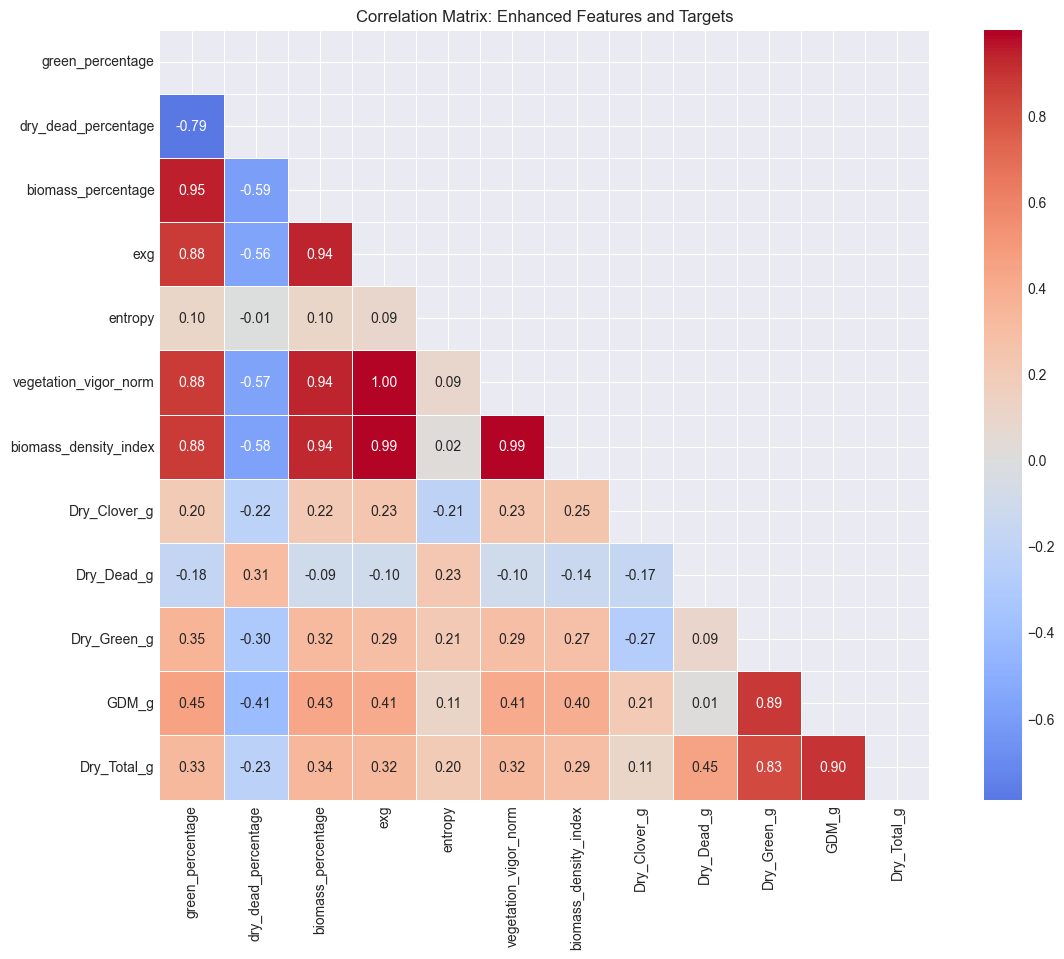

In [3]:


# %% [markdown]
# ## 11. Visualize Feature Relationships

# %%
# Create interactive visualization of feature relationships
import plotly.express as px

# Select key features for visualization
key_features_for_viz = [
    'green_percentage',
    'dry_dead_percentage',
    'biomass_percentage',
    'exg',
    'entropy',
    'vegetation_vigor_norm',
    'biomass_density_index'
]

# Create scatter plot matrix
fig = px.scatter_matrix(
    pd.concat([X_enhanced[key_features_for_viz], y], axis=1),
    dimensions=key_features_for_viz[:4] + ['Dry_Total_g'],
    color=y['Dry_Total_g'],
    title="Feature Relationships with Dry Total Biomass",
    height=800
)

fig.update_traces(diagonal_visible=False)
fig.show()

# Create correlation heatmap for enhanced features
plt.figure(figsize=(14, 10))
corr_matrix_enhanced = pd.concat([X_enhanced[key_features_for_viz], y], axis=1).corr()

mask = np.triu(np.ones_like(corr_matrix_enhanced, dtype=bool))
sns.heatmap(corr_matrix_enhanced, mask=mask, annot=True, cmap='coolwarm', 
            center=0, fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Matrix: Enhanced Features and Targets')

## machine learning

In [22]:
# %% [markdown]
# # Pasture Biomass Regression Modeling
# 
# ## Predict 5 target variables using extracted features
# 
# **Target Variables** (weights in parentheses):
# - Dry_Clover_g (0.1)
# - Dry_Dead_g (0.1)
# - Dry_Green_g (0.1)
# - Dry_Total_g (0.5)  **Main target**
# - GDM_g (0.2)
# 
# **Evaluation**: Weighted R² score

# %% [markdown]
# ## 1. Import Libraries

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Regression Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_regression
from sklearn.decomposition import PCA

# Model Evaluation
from sklearn.model_selection import cross_val_predict

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set random seeds
np.random.seed(42)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [36]:
# %% [markdown]
# ## 2. Load Complete Dataset

# %%
# Load your complete dataset (features + targets)
df = pd.read_csv(r'C:\Users\shamr\Downloads\csiro-biomass\test\train.csv')  # Replace with your actual file path

print("Dataset shape:", df.shape)
print("\nDataset columns:", df.columns.tolist())
print("\nFirst few rows:")
display(df.head())

# Identify feature columns and target columns
# Assuming target columns have '_g' suffix
target_columns = [col for col in df.columns if col.endswith('_G')]
feature_columns = [col for col in df.columns if col not in target_columns]

print(f"\nTarget columns ({len(target_columns)}): {target_columns}")
print(f"\nFeature columns ({len(feature_columns)}):")
print(feature_columns)

# Separate features and targets
X = df[feature_columns]
y = df[target_columns]

print(f"\nFeature matrix (X) shape: {X.shape}")
print(f"Target matrix (y) shape: {y.shape}")

# Check for missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in targets: {y.isnull().sum().sum()}")

# Display summary statistics
print("\nTarget statistics:")
print(y.iloc[:, :10].describe())

print("\nFeature statistics (first 10 features):")
print(X.iloc[:, :10].describe())

Dataset shape: (1785, 9)

Dataset columns: ['sample_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'target_name', 'target']

First few rows:


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750



Target columns (0): []

Feature columns (9):
['sample_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'target_name', 'target']

Feature matrix (X) shape: (1785, 9)
Target matrix (y) shape: (1785, 0)

Missing values in features: 0
Missing values in targets: 0.0

Target statistics:


ValueError: Cannot describe a DataFrame without columns

In [24]:
# %% [markdown]
# ## 3. Evaluation Metric: Weighted R²

# %%
# Define target weights as per competition
TARGET_WEIGHTS = {
    'Dry_Clover_g': 0.1,
    'Dry_Dead_g': 0.1,
    'Dry_Green_g': 0.1,
    'Dry_Total_g': 0.5,  # Main target
    'GDM_g': 0.2
}

def calculate_weighted_r2(y_true, y_pred, weights_dict=TARGET_WEIGHTS):
    """
    Calculate weighted R² score as per competition requirements.
    
    Parameters:
    -----------
    y_true : pandas DataFrame or numpy array
        True target values
    y_pred : pandas DataFrame or numpy array  
        Predicted target values
    weights_dict : dict
        Dictionary mapping target names to weights
        
    Returns:
    --------
    weighted_r2 : float
        Weighted R² score
    individual_r2 : dict
        R² scores for each target
    """
    
    # Convert to numpy arrays if DataFrames
    if isinstance(y_true, pd.DataFrame):
        y_true_array = y_true.values
        target_names = y_true.columns
    else:
        y_true_array = y_true
        target_names = list(weights_dict.keys())
    
    if isinstance(y_pred, pd.DataFrame):
        y_pred_array = y_pred.values
    else:
        y_pred_array = y_pred
    
    # Ensure shapes match
    if y_true_array.shape != y_pred_array.shape:
        raise ValueError(f"Shapes don't match: y_true {y_true_array.shape}, y_pred {y_pred_array.shape}")
    
    # Calculate individual R² scores
    individual_r2 = {}
    for i, target in enumerate(target_names):
        individual_r2[target] = r2_score(y_true_array[:, i], y_pred_array[:, i])
    
    # Calculate weighted R²
    n_samples = y_true_array.shape[0]
    n_targets = y_true_array.shape[1]
    
    # Create weight matrix
    weights = np.zeros((n_samples, n_targets))
    for i, target in enumerate(target_names):
        weights[:, i] = weights_dict.get(target, 1.0)
    
    # Calculate weighted sums
    y_true_weighted = y_true_array * weights
    y_pred_weighted = y_pred_array * weights
    
    # Weighted mean
    weighted_mean = np.sum(y_true_weighted) / np.sum(weights)
    
    # Weighted residual sum of squares
    rss = np.sum(weights * (y_true_array - y_pred_array) ** 2)
    
    # Weighted total sum of squares
    tss = np.sum(weights * (y_true_array - weighted_mean) ** 2)
    
    # Weighted R²
    if tss == 0:
        weighted_r2 = 0
    else:
        weighted_r2 = 1 - (rss / tss)
    
    return weighted_r2, individual_r2

def print_evaluation_metrics(y_true, y_pred, model_name="Model"):
    """Print comprehensive evaluation metrics."""
    
    weighted_r2, individual_r2 = calculate_weighted_r2(y_true, y_pred)
    
    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation")
    print(f"{'='*60}")
    print(f"Weighted R² Score: {weighted_r2:.4f}")
    print(f"\nIndividual R² Scores:")
    for target, score in individual_r2.items():
        print(f"  {target:<15s}: {score:.4f}")
    
    # Calculate additional metrics
    print(f"\nAdditional Metrics:")
    for i, target in enumerate(y_true.columns):
        mae = mean_absolute_error(y_true.iloc[:, i], y_pred.iloc[:, i])
        rmse = np.sqrt(mean_squared_error(y_true.iloc[:, i], y_pred.iloc[:, i]))
        print(f"  {target:<15s}: MAE={mae:.2f}, RMSE={rmse:.2f}")
    
    return weighted_r2, individual_r2


In [25]:
# %% [markdown]
# ## 4. Data Preprocessing

# %%
def preprocess_data(X, y, test_size=0.2, random_state=42):
    """
    Preprocess data: split, scale, handle missing values.
    """
    
    # Handle missing values
    X_filled = X.fillna(X.mean())
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_filled, y, test_size=test_size, random_state=random_state
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrames
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
    
    print(f"Training set: {X_train_scaled_df.shape[0]} samples")
    print(f"Test set: {X_test_scaled_df.shape[0]} samples")
    print(f"Number of features: {X_train_scaled_df.shape[1]}")
    
    return X_train_scaled_df, X_test_scaled_df, y_train, y_test, scaler

# %%
# Preprocess the data
X_train, X_test, y_train, y_test, scaler = preprocess_data(X, y)

Training set: 6 samples
Test set: 2 samples
Number of features: 68


In [26]:

# %% [markdown]
# ## 5. Regression Model Classes

# %%
class MultiTargetRegressionModel:
    """Base class for multi-target regression models."""
    
    def __init__(self, model_type='random_forest', **params):
        self.model_type = model_type
        self.params = params
        self.models = {}
        self.scaler = None
        self.feature_importances_ = None
        
    def fit(self, X_train, y_train):
        """Train the model."""
        
        self.targets = y_train.columns
        
        if self.model_type == 'random_forest':
            self.model = MultiOutputRegressor(
                RandomForestRegressor(n_estimators=100, random_state=42, **self.params)
            )
            
        elif self.model_type == 'gradient_boosting':
            self.model = MultiOutputRegressor(
                GradientBoostingRegressor(n_estimators=100, random_state=42, **self.params)
            )
            
        elif self.model_type == 'xgboost':
            self.models = {}
            for target in self.targets:
                model = xgb.XGBRegressor(
                    n_estimators=100,
                    learning_rate=0.1,
                    max_depth=5,
                    random_state=42,
                    **self.params
                )
                model.fit(X_train, y_train[target])
                self.models[target] = model
            return self
            
        elif self.model_type == 'lightgbm':
            self.models = {}
            for target in self.targets:
                model = lgb.LGBMRegressor(
                    n_estimators=100,
                    learning_rate=0.05,
                    num_leaves=31,
                    random_state=42,
                    **self.params
                )
                model.fit(X_train, y_train[target])
                self.models[target] = model
            return self
            
        elif self.model_type == 'linear':
            self.model = LinearRegression(**self.params)
            
        elif self.model_type == 'ridge':
            self.model = Ridge(random_state=42, **self.params)
            
        elif self.model_type == 'svr':
            self.model = MultiOutputRegressor(
                SVR(**self.params)
            )
            
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")
        
        # Fit the model
        if hasattr(self, 'model'):
            self.model.fit(X_train, y_train)
            
            # Get feature importances if available
            if hasattr(self.model, 'feature_importances_'):
                self.feature_importances_ = self.model.feature_importances_
            elif hasattr(self.model, 'estimators_'):
                # For multi-output models, average importances
                importances = []
                for estimator in self.model.estimators_:
                    if hasattr(estimator, 'feature_importances_'):
                        importances.append(estimator.feature_importances_)
                if importances:
                    self.feature_importances_ = np.mean(importances, axis=0)
        
        return self
    
    def predict(self, X):
        """Make predictions."""
        
        if self.model_type in ['xgboost', 'lightgbm']:
            predictions = {}
            for target in self.targets:
                predictions[target] = self.models[target].predict(X)
            y_pred = pd.DataFrame(predictions, columns=self.targets)
        else:
            y_pred_array = self.model.predict(X)
            y_pred = pd.DataFrame(y_pred_array, columns=self.targets)
        
        return y_pred
    
    def cross_validate(self, X, y, cv=5):
        """Perform cross-validation."""
        
        cv_scores = []
        individual_scores = {target: [] for target in self.targets}
        
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            print(f"  Fold {fold+1}/{cv}", end='\r')
            
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
            # Train model
            model_copy = MultiTargetRegressionModel(
                model_type=self.model_type, 
                **self.params
            )
            model_copy.fit(X_train_fold, y_train_fold)
            
            # Predict
            y_pred_fold = model_copy.predict(X_val_fold)
            
            # Calculate scores
            weighted_r2, individual_r2 = calculate_weighted_r2(y_val_fold, y_pred_fold)
            cv_scores.append(weighted_r2)
            
            for target in self.targets:
                individual_scores[target].append(individual_r2[target])
        
        print(f"  Cross-validation completed")
        
        cv_results = {
            'weighted_r2_mean': np.mean(cv_scores),
            'weighted_r2_std': np.std(cv_scores),
            'individual_r2': {target: np.mean(scores) for target, scores in individual_scores.items()}
        }
        
        return cv_results

In [27]:

class EnsembleRegressionModel:
    """Ensemble of multiple regression models."""
    
    def __init__(self, models_config):
        """
        Parameters:
        -----------
        models_config : list of tuples
            Each tuple: (model_type, params, weight)
        """
        self.models_config = models_config
        self.models = []
        self.weights = []
        
    def fit(self, X_train, y_train):
        """Train all ensemble models."""
        
        for model_type, params, weight in self.models_config:
            print(f"Training {model_type}...")
            model = MultiTargetRegressionModel(model_type=model_type, **params)
            model.fit(X_train, y_train)
            self.models.append(model)
            self.weights.append(weight)
        
        # Normalize weights
        total_weight = sum(self.weights)
        self.weights = [w / total_weight for w in self.weights]
        
        return self
    
    def predict(self, X):
        """Weighted average of ensemble predictions."""
        
        predictions = []
        
        for model, weight in zip(self.models, self.weights):
            pred = model.predict(X)
            predictions.append(pred.values * weight)
        
        # Weighted average
        weighted_pred = sum(predictions)
        y_pred = pd.DataFrame(weighted_pred, columns=self.models[0].targets)
        
        return y_pred

In [28]:
# %% [markdown]
# ## 6. Train and Evaluate Models

# %%
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train multiple models and compare their performance."""
    
    models_to_test = [
        ('Random Forest', 'random_forest', {}),
        ('Gradient Boosting', 'gradient_boosting', {}),
        ('Ridge Regression', 'ridge', {'alpha': 1.0}),
        ('Linear Regression', 'linear', {}),
    ]
    
    results = {}
    
    for model_name, model_type, params in tqdm(models_to_test, desc="Training models"):
        print(f"\n{'='*60}")
        print(f"Training {model_name}...")
        
        # Train model
        model = MultiTargetRegressionModel(model_type=model_type, **params)
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Evaluate
        train_r2, _ = calculate_weighted_r2(y_train, y_pred_train)
        test_r2, test_individual_r2 = calculate_weighted_r2(y_test, y_pred_test)
        
        # Store results
        results[model_name] = {
            'model': model,
            'train_weighted_r2': train_r2,
            'test_weighted_r2': test_r2,
            'test_individual_r2': test_individual_r2,
            'predictions_test': y_pred_test
        }
        
        # Print results
        print(f"\n{model_name} Results:")
        print(f"  Training Weighted R²: {train_r2:.4f}")
        print(f"  Test Weighted R²: {test_r2:.4f}")
        print(f"\n  Individual Test R² Scores:")
        for target, score in test_individual_r2.items():
            print(f"    {target:<15s}: {score:.4f}")
    
    return results

# %%
# Train and evaluate models
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

Training models:  25%|██▌       | 1/4 [00:00<00:00,  8.53it/s]


Training Random Forest...

Random Forest Results:
  Training Weighted R²: 0.9773
  Test Weighted R²: -0.2570

  Individual Test R² Scores:
    Dry_Clover_G   : -5.4161
    Dry_Dead_G     : -8.8945
    Dry_Green_G    : -0.7994
    Dry_Total_G    : -48.2095

Training Gradient Boosting...

Gradient Boosting Results:

Training models: 100%|██████████| 4/4 [00:00<00:00, 23.77it/s]


  Training Weighted R²: 1.0000
  Test Weighted R²: -0.0911

  Individual Test R² Scores:
    Dry_Clover_G   : 0.1682
    Dry_Dead_G     : -8.1008
    Dry_Green_G    : -1.1359
    Dry_Total_G    : -13.0799

Training Ridge Regression...

Ridge Regression Results:
  Training Weighted R²: 0.9999
  Test Weighted R²: 0.7557

  Individual Test R² Scores:
    Dry_Clover_G   : -6.5858
    Dry_Dead_G     : -1.2908
    Dry_Green_G    : 0.9516
    Dry_Total_G    : 0.6711

Training Linear Regression...

Linear Regression Results:
  Training Weighted R²: 1.0000
  Test Weighted R²: 0.7576

  Individual Test R² Scores:
    Dry_Clover_G   : -6.9060
    Dry_Dead_G     : -1.2585
    Dry_Green_G    : 0.9278
    Dry_Total_G    : 0.6817


In [29]:
# %% [markdown]
# ## 7. Model Comparison

# %%
def compare_models(results):
    """Compare performance of all trained models."""
    
    # Create comparison DataFrame
    comparison_data = []
    
    for model_name, result in results.items():
        comparison_data.append({
            'Model': model_name,
            'Train_R2': result['train_weighted_r2'],
            'Test_R2': result['test_weighted_r2'],
            **result['test_individual_r2']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Sort by Test_R2
    comparison_df = comparison_df.sort_values('Test_R2', ascending=False)
    
    print("\n" + "="*80)
    print("MODEL COMPARISON (sorted by Test Weighted R²)")
    print("="*80)

    return comparison_df

# %%
# Compare models
comparison_df = compare_models(results)

comparison_df.head(10)




MODEL COMPARISON (sorted by Test Weighted R²)


,Model,Train_R2,Test_R2,Dry_Clover_G,Dry_Dead_G,Dry_Green_G,Dry_Total_G
3,Linear Regression,1.000000,0.757583,-6.906017,-1.258460,0.927780,0.681678
2,Ridge Regression,0.999898,0.755684,-6.585819,-1.290769,0.951647,0.671122
1,Gradient Boosting,1.000000,-0.091080,0.168199,-8.100790,-1.135876,-13.079938
0,Random Forest,0.977343,-0.257042,-5.416150,-8.894459,-0.799415,-48.209483


In [30]:
# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")
print(f"Test Weighted R²: {comparison_df.iloc[0]['Test_R2']:.4f}")


Best Model: Linear Regression
Test Weighted R²: 0.7576


In [31]:
# %% [markdown]
# ## Save Trained Model for Future Use

# %%
import joblib
import pickle

# Save the complete model pipeline
def save_model_pipeline(model, scaler, feature_names, model_name='pasture_biomass_model'):
    """
    Save the complete model pipeline including model, scaler, and metadata.
    
    Parameters:
    -----------
    model : trained model
        Your trained regression model
    scaler : StandardScaler
        Scaler used during training
    feature_names : list
        List of feature names used in training
    model_name : str
        Base name for saved files
    """
    
    # Create a dictionary with all components
    model_pipeline = {
        'model': model,
        'scaler': scaler,
        'feature_names': feature_names,
        'target_names': ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g'],
        'target_weights': {
            'Dry_Clover_g': 0.1,
            'Dry_Dead_g': 0.1,
            'Dry_Green_g': 0.1,
            'Dry_Total_g': 0.5,
            'GDM_g': 0.2
        },
        'model_info': {
            'type': type(model).__name__,
            'n_features': len(feature_names),
            'saved_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        }
    }
    
    # Save using joblib (better for sklearn models)
    joblib.dump(model_pipeline, f'{model_name}.joblib')
    
    # Also save as pickle for compatibility
    with open(f'{model_name}.pkl', 'wb') as f:
        pickle.dump(model_pipeline, f)
    
    print(f"✓ Model saved as '{model_name}.joblib' and '{model_name}.pkl'")
    print(f"  - Model type: {type(model).__name__}")
    print(f"  - Number of features: {len(feature_names)}")
    print(f"  - Target variables: {model_pipeline['target_names']}")

# %%
# Save your trained model
# Replace with your actual trained model, scaler, and feature names
save_model_pipeline(best_model, scaler, X_train.columns.tolist(), 'pasture_biomass_model')

✓ Model saved as 'pasture_biomass_model.joblib' and 'pasture_biomass_model.pkl'
  - Model type: MultiTargetRegressionModel
  - Number of features: 68
  - Target variables: ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']


# prediction / testing on some train image

In [32]:
# %% [markdown]
# ## Load Saved Model

# %%
def load_model_pipeline(model_path='pasture_biomass_model.joblib'):
    """
    Load the complete model pipeline.
    
    Parameters:
    -----------
    model_path : str
        Path to saved model file
        
    Returns:
    --------
    model_pipeline : dict
        Dictionary containing model, scaler, and metadata
    """
    
    try:
        # Try joblib first (preferred for sklearn)
        model_pipeline = joblib.load(model_path)
        print(f"✓ Model loaded from '{model_path}' using joblib")
    except:
        try:
            # Try pickle if joblib fails
            with open(model_path, 'rb') as f:
                model_pipeline = pickle.load(f)
            print(f"✓ Model loaded from '{model_path}' using pickle")
        except Exception as e:
            print(f"✗ Error loading model: {e}")
            return None
    
    # Display model info
    print(f"\nModel Information:")
    print(f"  - Model type: {model_pipeline['model_info']['type']}")
    print(f"  - Features: {model_pipeline['model_info']['n_features']}")
    print(f"  - Targets: {', '.join(model_pipeline['target_names'])}")
    print(f"  - Saved date: {model_pipeline['model_info']['saved_date']}")
    
    return model_pipeline

# %%
# Load the model
model_pipeline = load_model_pipeline('pasture_biomass_model.joblib')

# Extract components
model = model_pipeline['model']
scaler = model_pipeline['scaler']
feature_names = model_pipeline['feature_names']


✓ Model loaded from 'pasture_biomass_model.joblib' using joblib

Model Information:
  - Model type: MultiTargetRegressionModel
  - Features: 68
  - Targets: Dry_Clover_g, Dry_Dead_g, Dry_Green_g, Dry_Total_g, GDM_g
  - Saved date: 2026-01-27 23:18:21


In [33]:

def predict_with_loaded_model(image_path, model_pipeline, extractor):
    """
    Make predictions using a loaded model pipeline.
    
    Parameters:
    -----------
    image_path : str
        Path to the image file
    model_pipeline : dict
        Loaded model pipeline
    extractor : PastureImageFeatureExtractor
        Feature extractor
        
    Returns:
    --------
    predictions : dict
        Dictionary with target predictions
    """
    
    # Extract components from pipeline
    model = model_pipeline['model']
    scaler = model_pipeline['scaler']
    feature_names = model_pipeline['feature_names']
    target_names = model_pipeline['target_names']
    
    # Extract features from image
    features = extractor.extract_features_from_image(image_path) 
    
    if features is None:
        print(f"Failed to extract features from {image_path}")
        return None
    
    # Convert to DataFrame
    features_df = pd.DataFrame([features])
    
    # Ensure all expected features are present
    for feat in feature_names:
        if feat not in features_df.columns:
            features_df[feat] = 0
    
    # Reorder columns
    features_df = features_df[feature_names]
    
    # Scale features
    features_scaled = scaler.transform(features_df)
    
    # Make prediction
    predictions = model.predict(features_scaled)
    
    # Format predictions - SIMPLER FIX
    pred_dict = {}
    
    if isinstance(predictions, pd.DataFrame):
        # If predictions is DataFrame, map column names
        for model_target in target_names:
            # Check if this target exists in predictions
            if model_target in predictions.columns:
                pred_dict[model_target] = predictions.iloc[0][model_target]
            else:
                # Try uppercase version
                uppercase_target = model_target.replace('_g', '_G')
                if uppercase_target in predictions.columns:
                    pred_dict[model_target] = predictions.iloc[0][uppercase_target]
                else:
                    pred_dict[model_target] = 0  # Default if missing
                    
    elif isinstance(predictions, np.ndarray):
        # For array predictions, assume they're in same order as target_names
        for i, model_target in enumerate(target_names):
            if i < predictions.shape[1]:
                pred_dict[model_target] = predictions[0, i]
            else:
                pred_dict[model_target] = 0
    
    return pred_dict

In [34]:


# %%
# Example usage for single image prediction
def test_single_image_with_saved_model(image_path, model_file='pasture_biomass_model.joblib'):
    """
    Test a single image with saved model.
    
    Parameters:
    -----------
    image_path : str
        Path to test image
    model_file : str
        Path to saved model file
    """
    
    # Load model
    model_pipeline = load_model_pipeline(model_file)
    
    if model_pipeline is None:
        return
    
    # Initialize feature extractor
    extractor = PastureFeatureExtractor()
    
    # Make prediction
    predictions = predict_with_loaded_model(image_path, model_pipeline, extractor)
    
    if predictions:
        print(f"\nPredictions for {image_path}:")
        print("="*50)
        for target, value in predictions.items():
            weight = model_pipeline['target_weights'].get(target, 'N/A')
            print(f"{target:<15s}: {value:>8.2f} g  (Weight: {weight})")
        
        # Calculate weighted score
        weighted_score = 0
        for target, value in predictions.items():
            weight = model_pipeline['target_weights'].get(target, 0)
            weighted_score += value * weight
        
        print(f"\nWeighted Biomass Score: {weighted_score:.2f}")
        
        return predictions
    else:
        print("Failed to make predictions")
        return None

In [35]:

# Load the feature extractor class first
# Then load and test
from scipy import stats
predictions = test_single_image_with_saved_model('/Users/harikrishnan/sample torch app/kaggle code/test/ID8209776.jpeg', 
                                                 '/Users/harikrishnan/sample torch app/kaggle code/pasture_biomass_model.joblib')

✓ Model loaded from '/Users/harikrishnan/sample torch app/kaggle code/pasture_biomass_model.joblib' using joblib

Model Information:
  - Model type: MultiTargetRegressionModel
  - Features: 68
  - Targets: Dry_Clover_g, Dry_Dead_g, Dry_Green_g, Dry_Total_g, GDM_g
  - Saved date: 2026-01-27 23:18:21

Predictions for /Users/harikrishnan/sample torch app/kaggle code/test/ID8209776.jpeg:
Dry_Clover_g   :     1.35 g  (Weight: 0.1)
Dry_Dead_g     :    53.28 g  (Weight: 0.1)
Dry_Green_g    :    13.89 g  (Weight: 0.1)
Dry_Total_g    :     8.93 g  (Weight: 0.5)
GDM_g          :     0.00 g  (Weight: 0.2)

Weighted Biomass Score: 11.32


In [36]:
predictions = test_single_image_with_saved_model('/Users/harikrishnan/sample torch app/kaggle code/test/ID94564238.jpeg', 
                                                 '/Users/harikrishnan/sample torch app/kaggle code/pasture_biomass_model.joblib')

✓ Model loaded from '/Users/harikrishnan/sample torch app/kaggle code/pasture_biomass_model.joblib' using joblib

Model Information:
  - Model type: MultiTargetRegressionModel
  - Features: 68
  - Targets: Dry_Clover_g, Dry_Dead_g, Dry_Green_g, Dry_Total_g, GDM_g
  - Saved date: 2026-01-27 23:18:21

Predictions for /Users/harikrishnan/sample torch app/kaggle code/test/ID94564238.jpeg:
Dry_Clover_g   :     3.36 g  (Weight: 0.1)
Dry_Dead_g     :    77.78 g  (Weight: 0.1)
Dry_Green_g    :    33.19 g  (Weight: 0.1)
Dry_Total_g    :    36.74 g  (Weight: 0.5)
GDM_g          :     0.00 g  (Weight: 0.2)

Weighted Biomass Score: 29.80
